In [1]:
import io
import os
import sys
import csv
import gzip
import time
import json
import secrets
import multiprocessing
import subprocess
import resource
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
from plotnine import *
import numpy as np
import scipy as sp
import statsmodels.api as sm
import random
from collections import Counter
import seaborn as sns
import matplotlib.colors as mcolors
from matplotlib.ticker import FuncFormatter
import itertools
import collections
import patchworklib as pw
sys.path.append('/well/band/users/rbx225/software/lcwgsus/')
import lcwgsus
from lcwgsus.variables import *
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

pd.options.mode.chained_assignment = None
%cd /gpfs3/well/band/users/rbx225/GAMCC/

# from matplotlib import colormaps
# list(colormaps)

/gpfs3/well/band/users/rbx225/GAMCC


<Figure size 100x100 with 0 Axes>

In [18]:
configfile = "/well/band/users/rbx225/GAMCC/pipelines/config.json"
with open(configfile, 'r') as file:
    data = json.load(file)
    
imp_dirs = data['imputation_dir']
mini_imp_dirs = data['mini_imputation_dir']
lr_imp_dirs = data['lr_imputation_dir']
sr_imp_dirs = data['sr_imputation_dir']


for i in sr_imp_dirs:
    print(i)

/well/band/users/rbx225/GAMCC/results/imputation_comparison/sr_simulation/lc_oneKG--hc--snps_gw/


# Plot sample metrics

Text(0, 0.5, 'Duplication Rate')

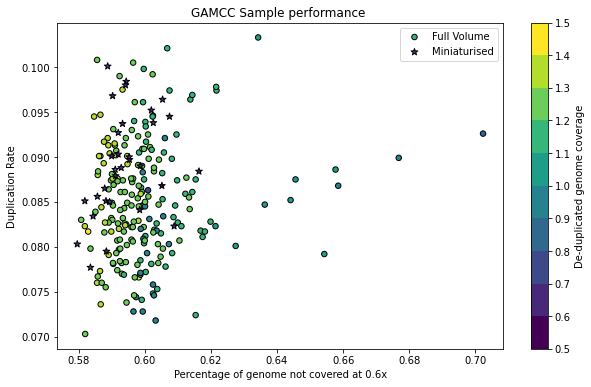

In [2]:
# util
metrics = pd.read_csv('results/metrics.csv')
fv = metrics[~metrics['Sample_Name'].str.contains('mini')]
mini = metrics[metrics['Sample_Name'].str.contains('mini')]

title = 'GAMCC Sample performance '

plt.figure(figsize=(10, 6))
ax = plt.subplot(1, 1, 1)
plt.grid(False)

cmap = plt.get_cmap('viridis')
magnitude = 10
bounds = np.linspace(0.5, 1.5, num = magnitude+1)
norm = mcolors.BoundaryNorm(bounds, cmap.N)

plt.scatter(fv['Subsample_Uncoverage_0.6x'], fv['Dup_Rate'], c = fv['Coverage'], edgecolor='black', cmap=cmap, norm=norm, s = 30, marker = 'o', label = 'Full Volume')
im = plt.scatter(mini['Subsample_Uncoverage_0.6x'], mini['Dup_Rate'], c = mini['Coverage'], edgecolor='black', cmap=cmap, norm=norm, s = 50, marker = '*', label = 'Miniaturised')
plt.colorbar(im, boundaries=bounds, ticks = bounds, label='De-duplicated genome coverage')

plt.xlabel('Percentage of genome not covered at 0.6x')
plt.title(title)
plt.legend()
plt.ylabel('Duplication Rate')
# ax = plt.gca()
# ax.grid()

# PCA comparison

In [21]:
ethnic = pd.read_csv('data/metadata/ethnic_group.csv')
ethnic = ethnic.rename(columns = {'Chip_Name': 'FID'})
sl = pd.read_csv(SAMPLE_LINKER_FILE)
sl = sl[~sl['Sample_Name'].str.contains('mini')]
sl = {k:v for k,v in zip(sl['Sample_Name'], sl['Chip_Name'])}
PCchip = pd.read_csv('results/chip/qc/PCs/PCs.eigenvec', sep = ' ', header = None, names = ['FID', 'IID'] + ['PC' + str(i) for i in range(1,11)])
PCchip = PCchip.drop(columns = 'IID')
PClc = pd.read_csv('results/wip_vcfs/oneKG/chip_sites/PCs.eigenvec', sep = ' ', header = None, names = ['FID', 'IID'] + ['PC' + str(i) for i in range(1,11)])
PClc = PClc[~PClc['IID'].str.contains('mini')]
PClc = PClc.drop(columns = 'IID')
lc_to_retain = lcwgsus.find_matching_samples(PCchip['FID'].values, rename_map = sl, lc = 'lc')
PClc = PClc[PClc['FID'].isin(lc_to_retain)]
def recode_names(r, sl = sl):
    r['FID'] = sl[r['FID']]
    return r
PClc = PClc.apply(recode_names, axis = 1)
PCchip = pd.merge(PCchip, ethnic, on = 'FID')
PClc = pd.merge(PClc, ethnic, on = 'FID')

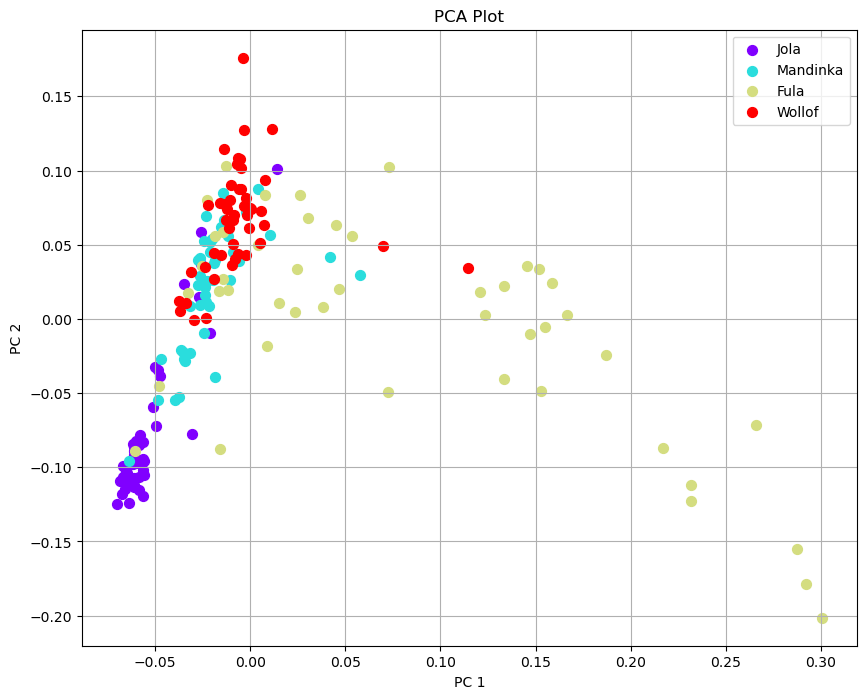

In [22]:
lcwgsus.plot_pc(PClc)

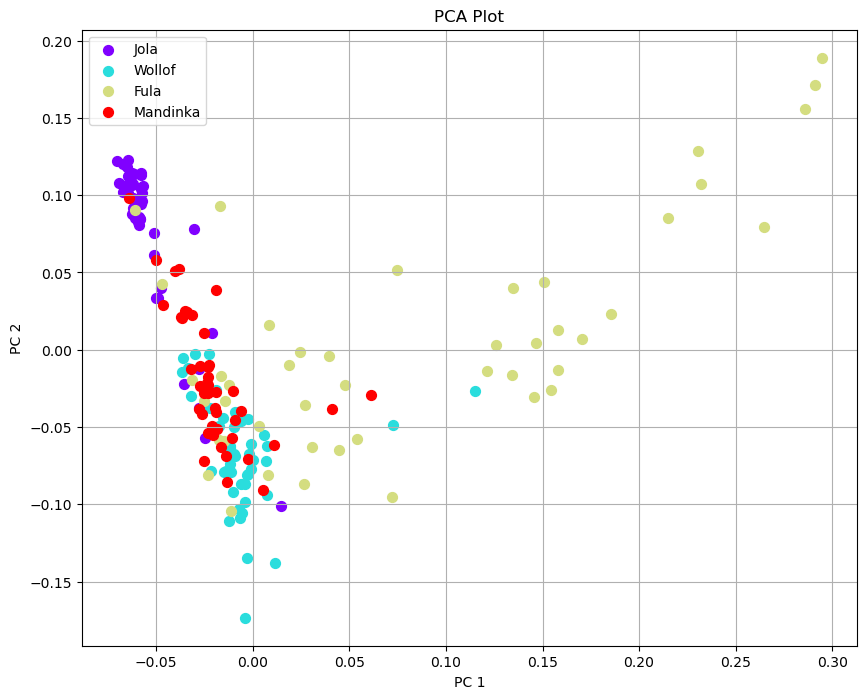

In [23]:
lcwgsus.plot_pc(PCchip)

# Full comparison across runs

In [20]:
ix = [0,11,14]
imp_dirs = [imp_dirs[i] for i in ix]
impaccs = []
for d in imp_dirs:
    v = pd.read_csv(d + "impacc/all_samples/by_sample/all.v.impacc.tsv", sep = '\t')
    impaccs.append(v)

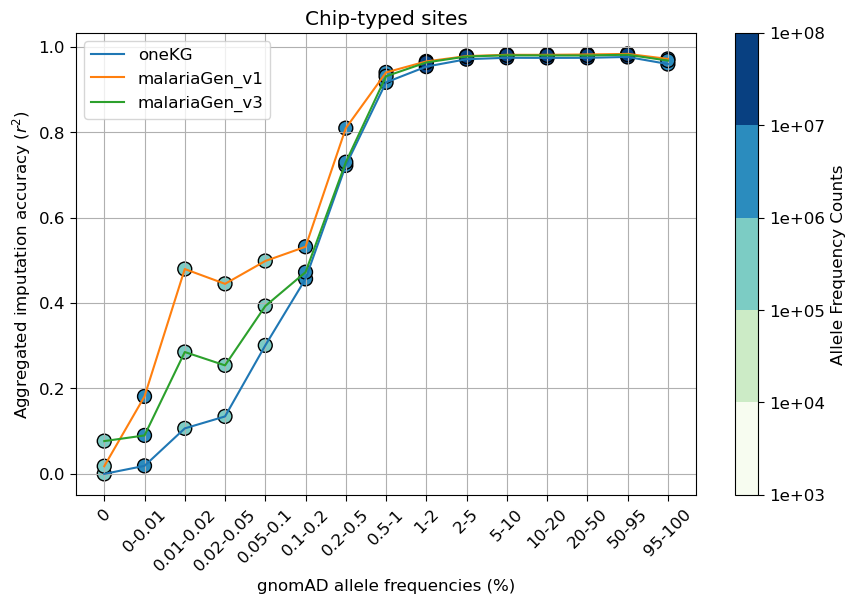

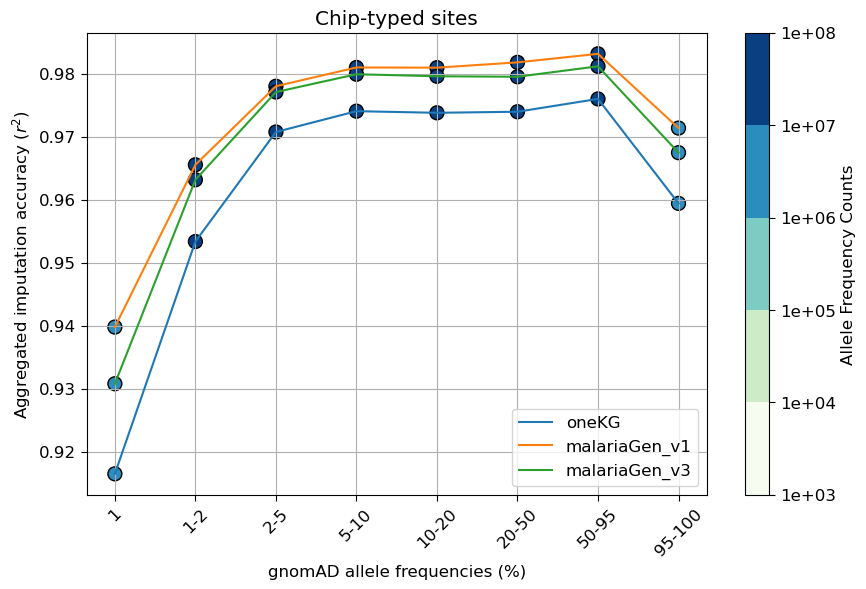

In [23]:
dfs = impaccs
labels = ['oneKG', 'malariaGen_v1', 'malariaGen_v3']
title = 'Chip-typed sites'

lcwgsus.plot_imputation_accuracy_gw(dfs, labels = labels, title = title)
lcwgsus.plot_imputation_accuracy_gw(dfs, labels = labels, threshold = 0.01, title = title)

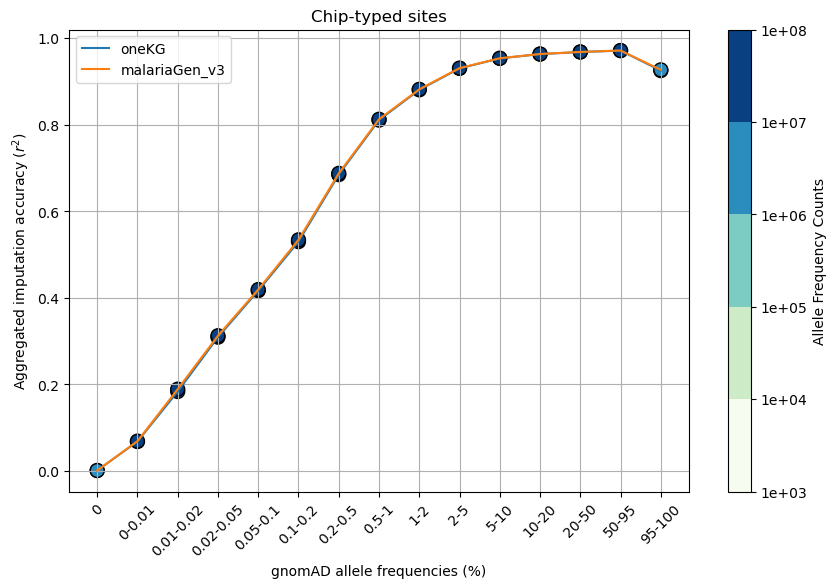

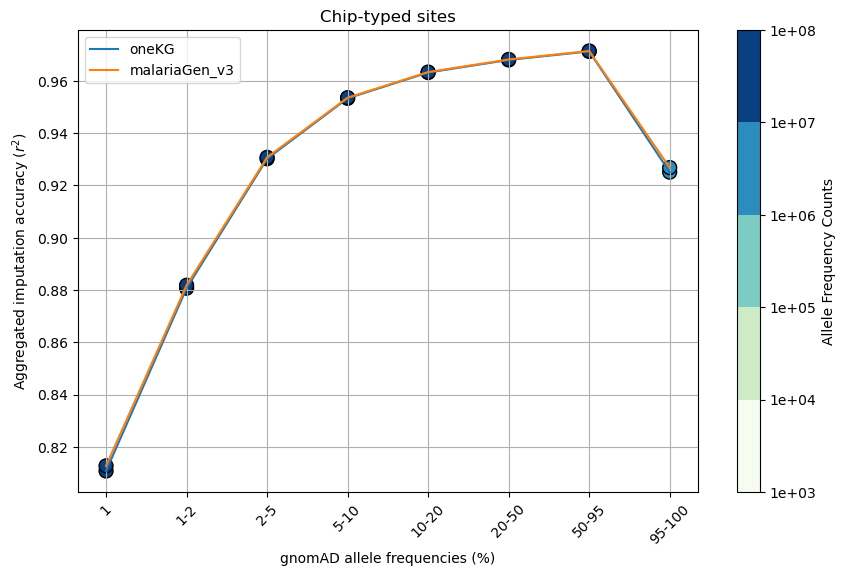

In [17]:
ixs = [3,13]
dfs = [impaccs[i] for i in ixs]
labels = ['oneKG', 'malariaGen_v3']
title = 'Chip-typed sites'

lcwgsus.plot_imputation_accuracy_gw(dfs, labels = labels, title = title)
lcwgsus.plot_imputation_accuracy_gw(dfs, labels = labels, threshold = 0.01, title = title)

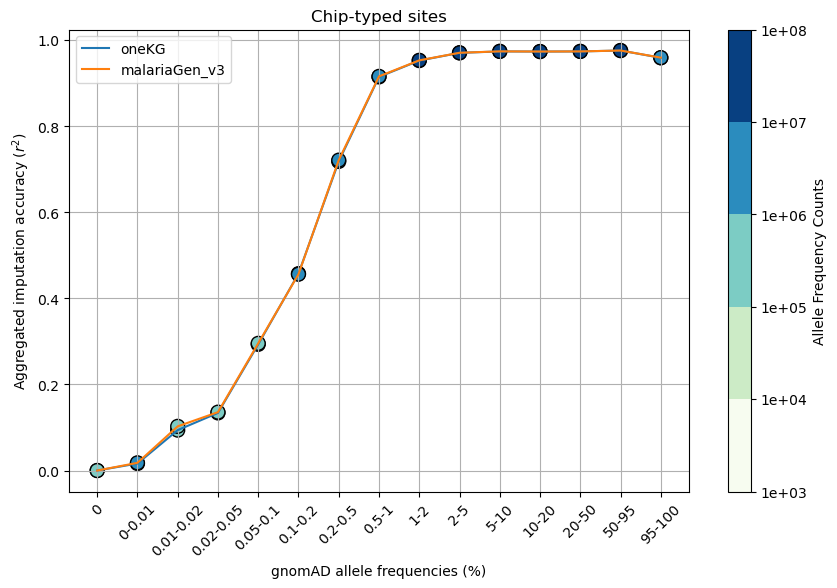

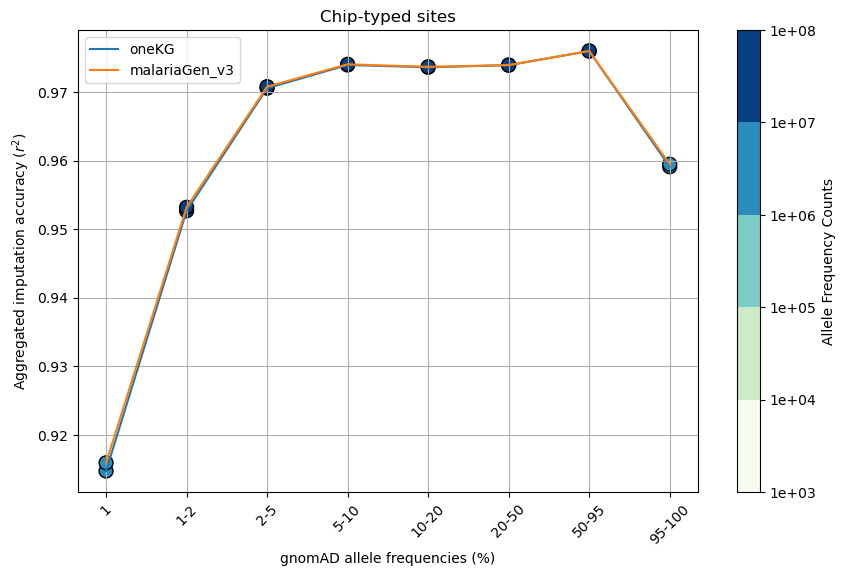

In [18]:
ixs = [0,11]
dfs = [impaccs[i] for i in ixs]
labels = ['oneKG', 'malariaGen_v3']
title = 'Chip-typed sites'

lcwgsus.plot_imputation_accuracy_gw(dfs, labels = labels, title = title)
lcwgsus.plot_imputation_accuracy_gw(dfs, labels = labels, threshold = 0.01, title = title)

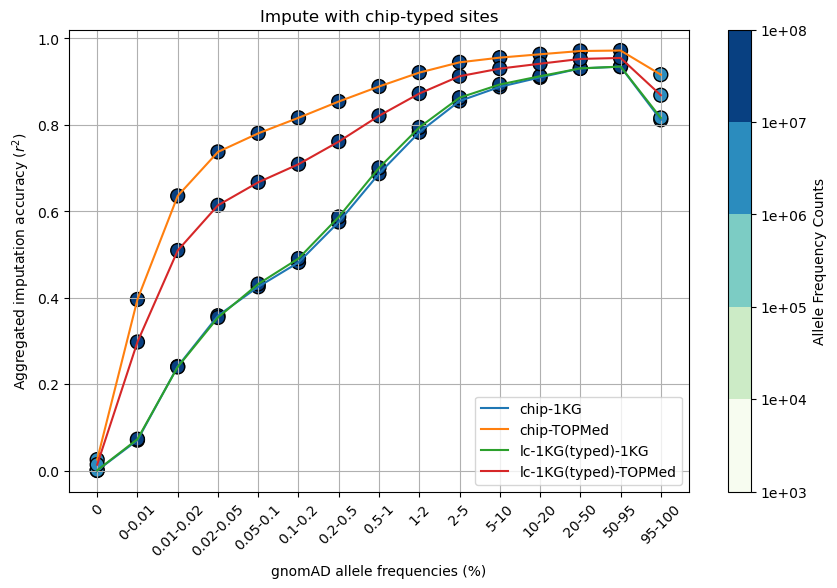

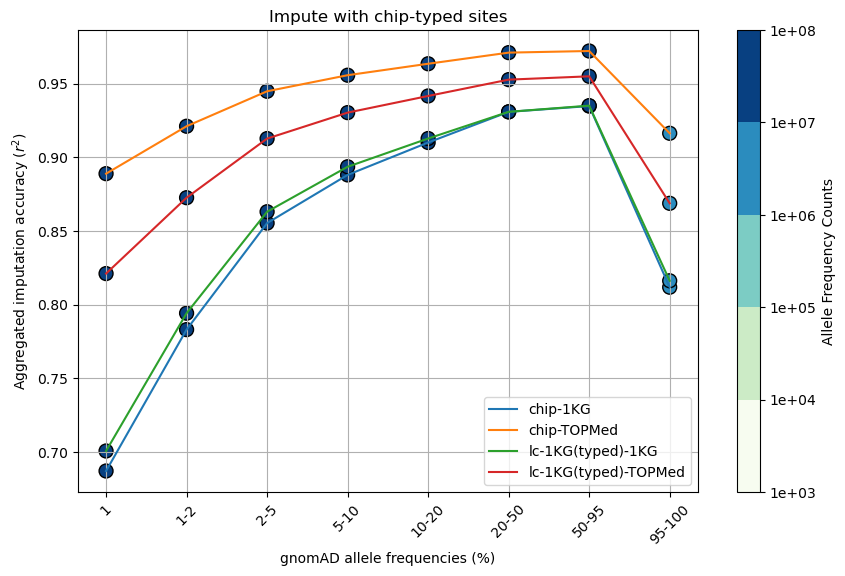

In [24]:
ixs = [2,4,7,8]
dfs = [impaccs[i] for i in ixs]
labels = ['chip-1KG', 'chip-TOPMed', 'lc-1KG(typed)-1KG', 'lc-1KG(typed)-TOPMed']
title = 'Impute with chip-typed sites'

lcwgsus.plot_imputation_accuracy_gw(dfs, labels = labels, title = title)
lcwgsus.plot_imputation_accuracy_gw(dfs, labels = labels, threshold = 0.01, title = title)

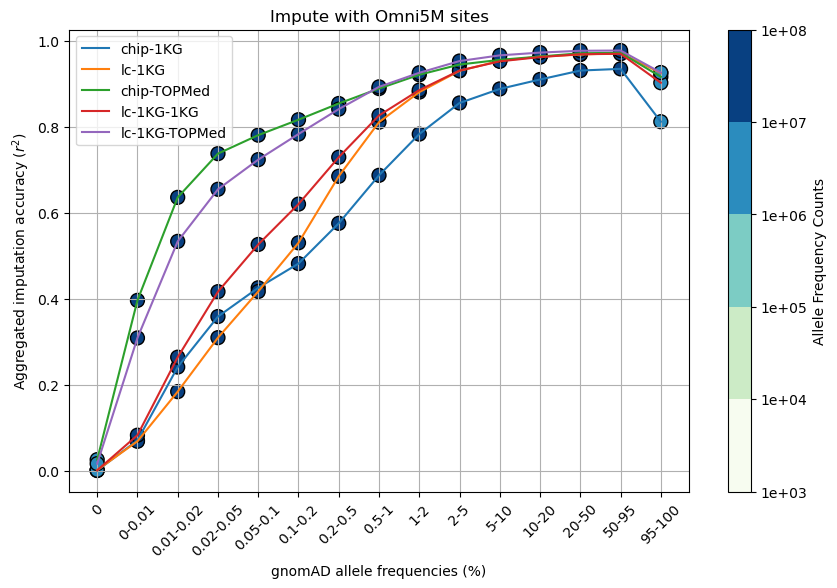

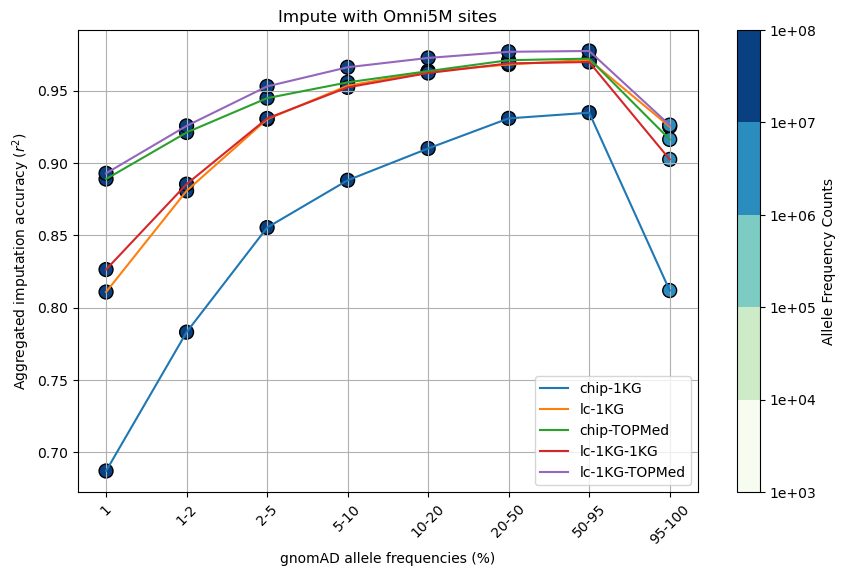

In [25]:
ixs = [2,3,4,5,6]
dfs = [impaccs[i] for i in ixs]
labels = ['chip-1KG', 'lc-1KG', 'chip-TOPMed', 'lc-1KG-1KG', 'lc-1KG-TOPMed']
title = 'Impute with Omni5M sites'

lcwgsus.plot_imputation_accuracy_gw(dfs, labels = labels, title = title)
lcwgsus.plot_imputation_accuracy_gw(dfs, labels = labels, threshold = 0.01, title = title)

In [9]:
imp_dirs

['/well/band/users/rbx225/GAMCC/results/imputation_comparison/vanilla/lc_oneKG--chip--typed/',
 '/well/band/users/rbx225/GAMCC/results/imputation_comparison/vanilla/lc_oneKG--chip--typed_high_info/',
 '/well/band/users/rbx225/GAMCC/results/imputation_comparison/vanilla/chip_oneKG--hc--snps_gw/',
 '/well/band/users/rbx225/GAMCC/results/imputation_comparison/vanilla/lc_oneKG--hc--snps_gw/',
 '/well/band/users/rbx225/GAMCC/results/imputation_comparison/vanilla/chip_topmed--hc--snps_gw/',
 '/well/band/users/rbx225/GAMCC/results/imputation_comparison/vanilla/lc_oneKG_oneKG--hc--snps_gw/',
 '/well/band/users/rbx225/GAMCC/results/imputation_comparison/vanilla/lc_oneKG_topmed--hc--snps_gw/',
 '/well/band/users/rbx225/GAMCC/results/imputation_comparison/vanilla/lc_oneKG_typed_oneKG--hc--snps_gw/',
 '/well/band/users/rbx225/GAMCC/results/imputation_comparison/vanilla/lc_oneKG_typed_topmed--hc--snps_gw/',
 '/well/band/users/rbx225/GAMCC/results/imputation_comparison/vanilla/lc_oneKG_highConfidenc

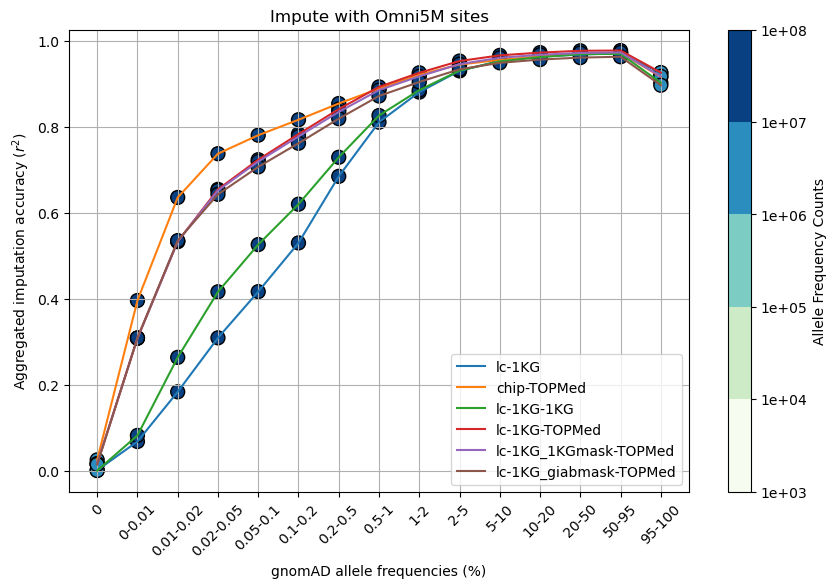

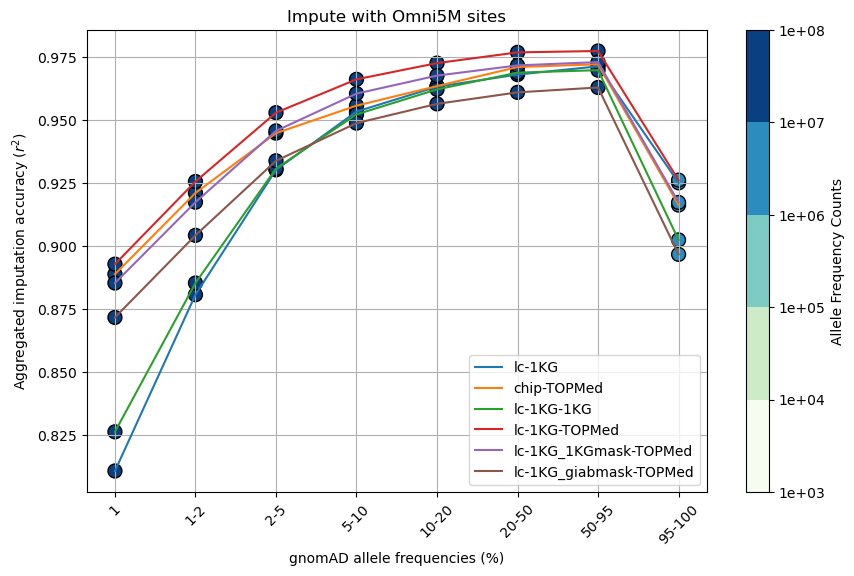

In [8]:
ixs = [3,4,5,6,9,10]
dfs = [impaccs[i] for i in ixs]
labels = ['lc-1KG', 'chip-TOPMed', 'lc-1KG-1KG', 'lc-1KG-TOPMed', 'lc-1KG_1KGmask-TOPMed', 'lc-1KG_giabmask-TOPMed']
title = 'Impute with Omni5M sites'

lcwgsus.plot_imputation_accuracy_gw(dfs, labels = labels, title = title)
lcwgsus.plot_imputation_accuracy_gw(dfs, labels = labels, threshold = 0.01, title = title)

# Plot FV-mini

In [ ]:
mini_impaccs = []
mini_imp_dirs = data['mini_imputation_dir']
for d in mini_imp_dirs:
    v = pd.read_csv(d + "impacc/all_samples/by_sample/all.v.impacc.tsv", sep = '\t')
    mini_impaccs.append(v)

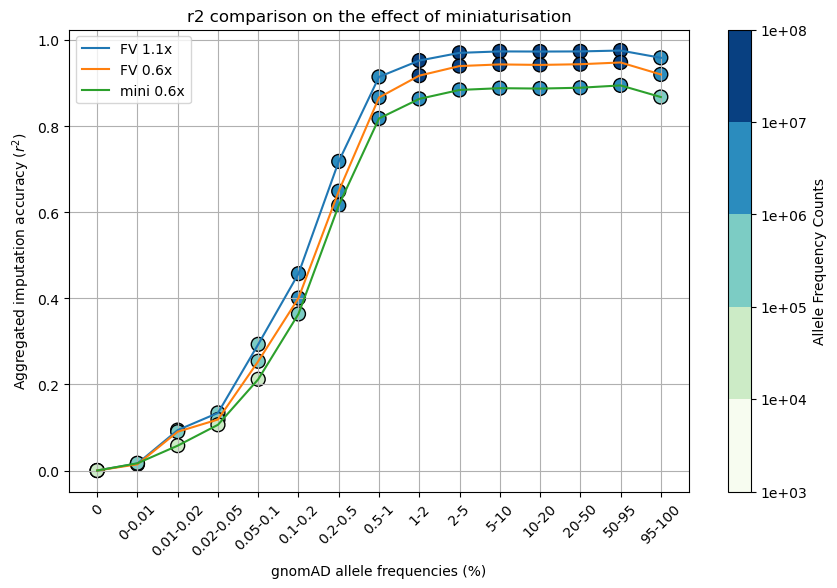

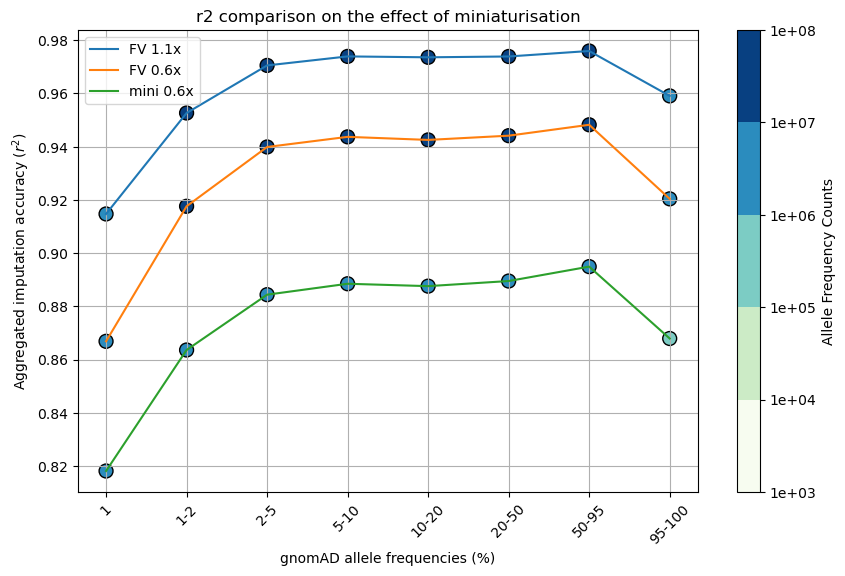

In [15]:
dfs = [impaccs[0]] + [mini_impaccs[0]] + [mini_impaccs[3]]
labels = ['FV 1.1x', 'FV 0.6x', 'mini 0.6x']
title = 'r2 comparison on the effect of miniaturisation'

lcwgsus.plot_imputation_accuracy_gw(dfs, labels = labels, title = title)
lcwgsus.plot_imputation_accuracy_gw(dfs, labels = labels, threshold = 0.01, title = title)

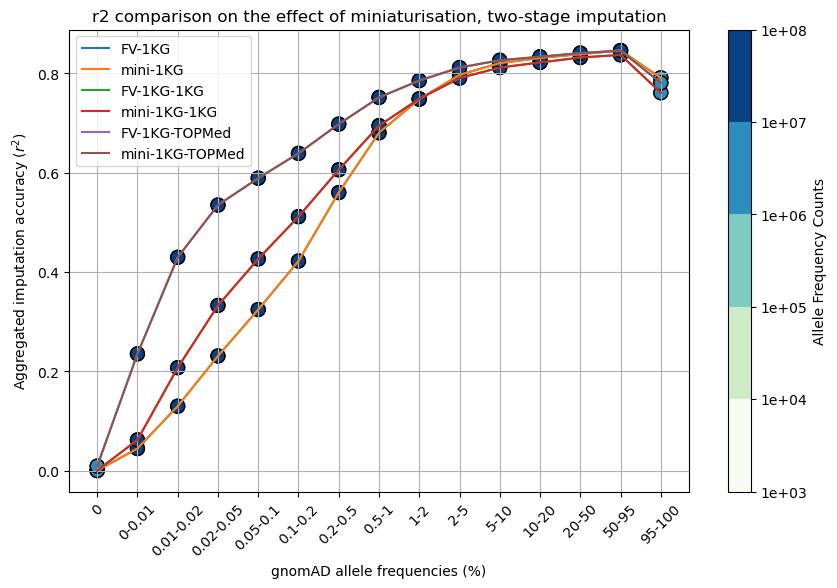

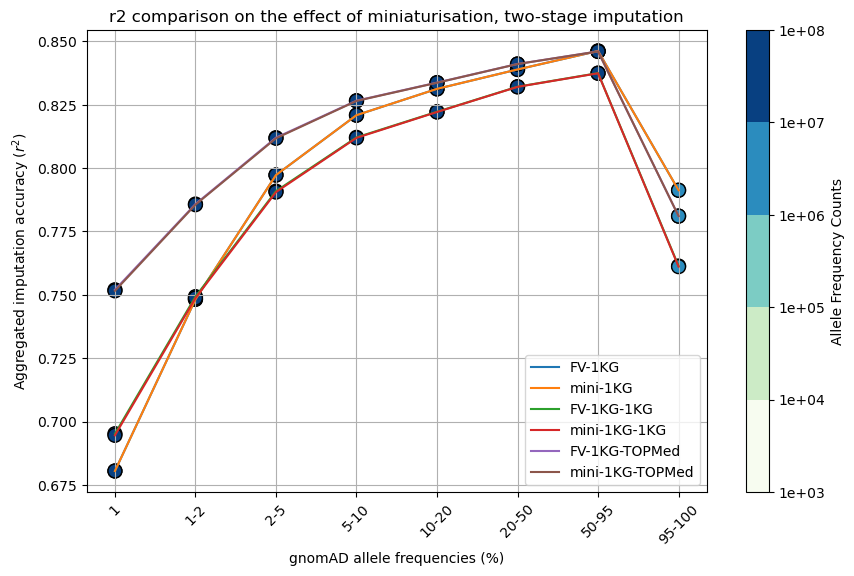

In [7]:
ixs = [2,5,6,7,8,9]
dfs = [mini_impaccs[i] for i in ixs]
labels = ['FV-1KG', 'mini-1KG', 'FV-1KG-1KG', 'mini-1KG-1KG', 'FV-1KG-TOPMed', 'mini-1KG-TOPMed']
title = 'r2 comparison on the effect of miniaturisation, two-stage imputation'

lcwgsus.plot_imputation_accuracy_gw(dfs, labels = labels, title = title)
lcwgsus.plot_imputation_accuracy_gw(dfs, labels = labels, threshold = 0.01, title = title)

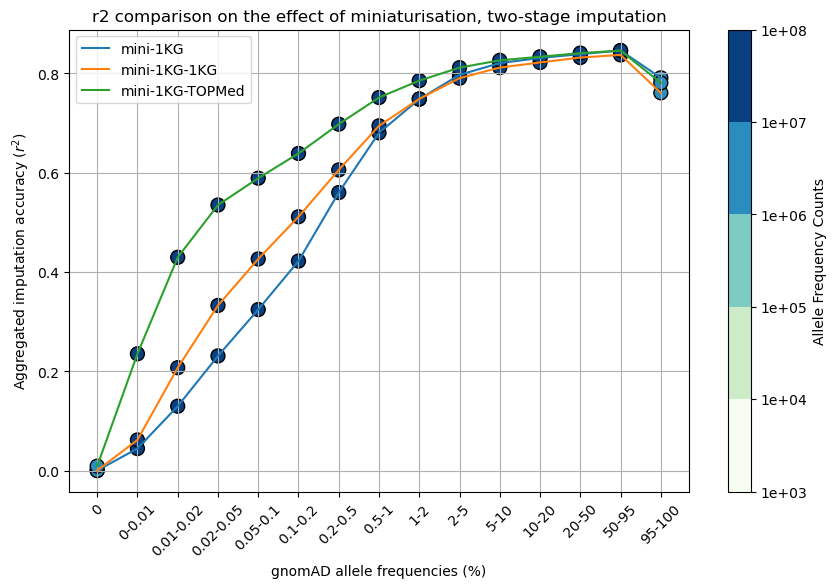

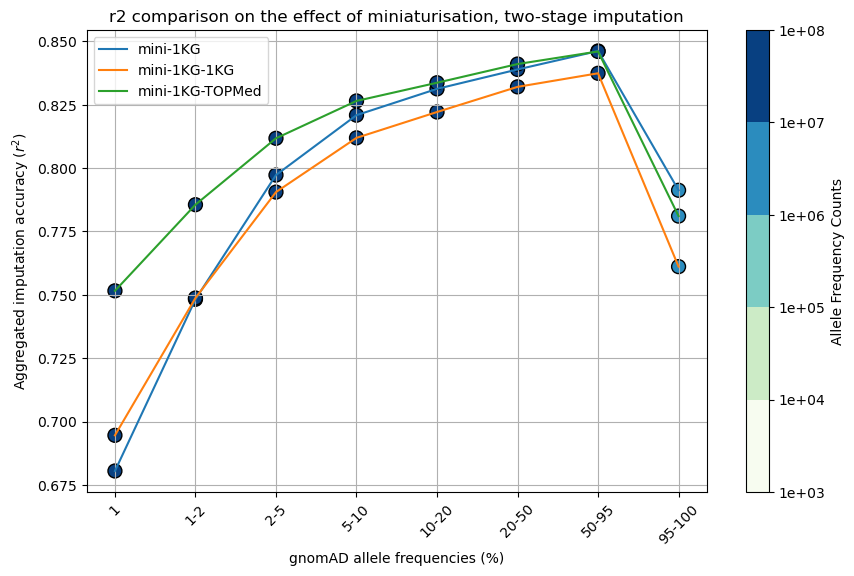

In [8]:
ixs = [5,7,9]
dfs = [mini_impaccs[i] for i in ixs]
labels = ['mini-1KG', 'mini-1KG-1KG', 'mini-1KG-TOPMed']
title = 'r2 comparison on the effect of miniaturisation, two-stage imputation'

lcwgsus.plot_imputation_accuracy_gw(dfs, labels = labels, title = title)
lcwgsus.plot_imputation_accuracy_gw(dfs, labels = labels, threshold = 0.01, title = title)

# Plot long-read simulation

In [2]:
lr_rls = ['500b', '600b', '800b', '1kb', '2kb', '5kb', '10kb', '20kb']

chrs = [pd.read_csv("/well/band/users/rbx225/GAMCC/results/imputation_comparison/lr_simulation/lc_oneKG--hc--snps_gw/impacc/all_samples/by_sample/chr" + i + ".v.tsv", sep = '\t') for i in CHROMOSOMES_ALL]
chrs[0]

lr_ary = []
for r in lr_rls:
    lr_impaccs = []
    for df in chrs:
        lr_impaccs.append(df[df['sample'] == r].drop(columns = 'sample'))
    lr_ary.append(lcwgsus.average_impacc_by_chr(lr_impaccs))

In [3]:
file_lst = ["/well/band/users/rbx225/GAMCC/data/lr_simulations/" + i + "/" + i + ".fastq.gz" for i in lr_rls]
for f in file_lst:
    lcwgsus.plot_rl_distribution(lcwgsus.get_rl_distribution(f))

ValueError: invalid literal for int() with base 10: ''

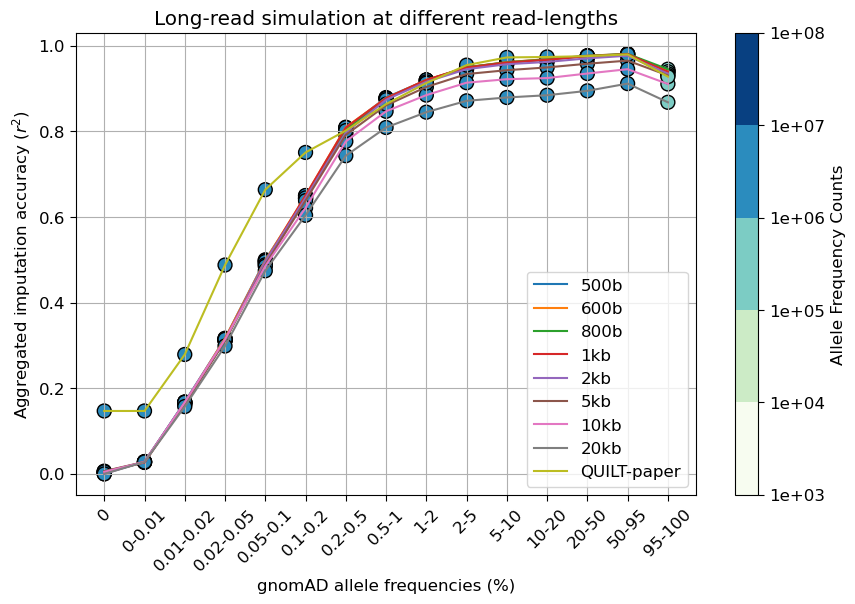

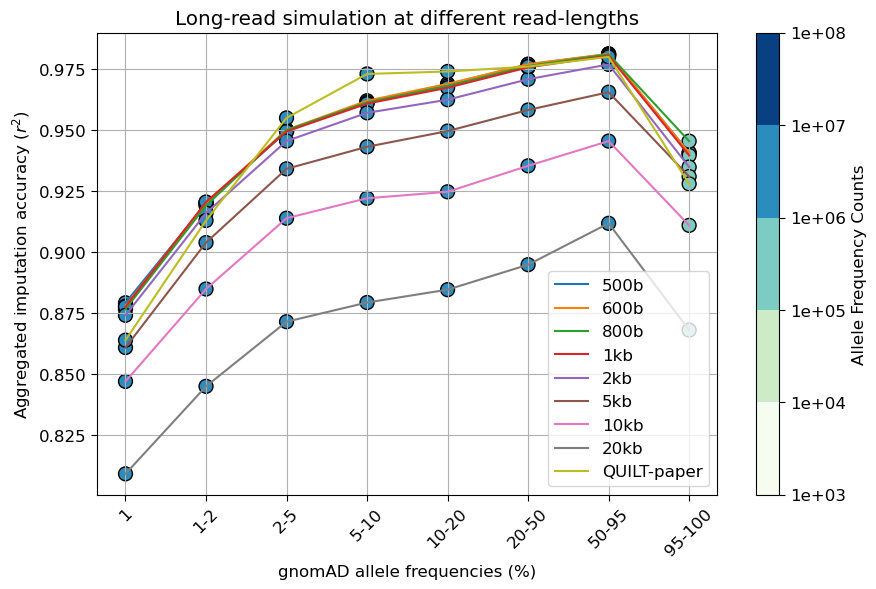

In [4]:
robbie = lr_ary[0][['AF', 'r2_AC']]
ont = [0.147, 0.147, 0.279, 0.488, 0.664, 0.751, 0.802, 0.864, 0.913, 0.955, 0.973, 0.974, 0.976, 0.98, 0.928]
robbie['r2'] = ont
robbie = robbie[['AF', 'r2', 'r2_AC']]

dfs = lr_ary + [robbie]
labels = lr_rls + ['QUILT-paper']
title = 'Long-read simulation at different read-lengths'

lcwgsus.plot_imputation_accuracy_gw(dfs, labels = labels, title = title)
lcwgsus.plot_imputation_accuracy_gw(dfs, labels = labels, threshold = 0.01, title = title)

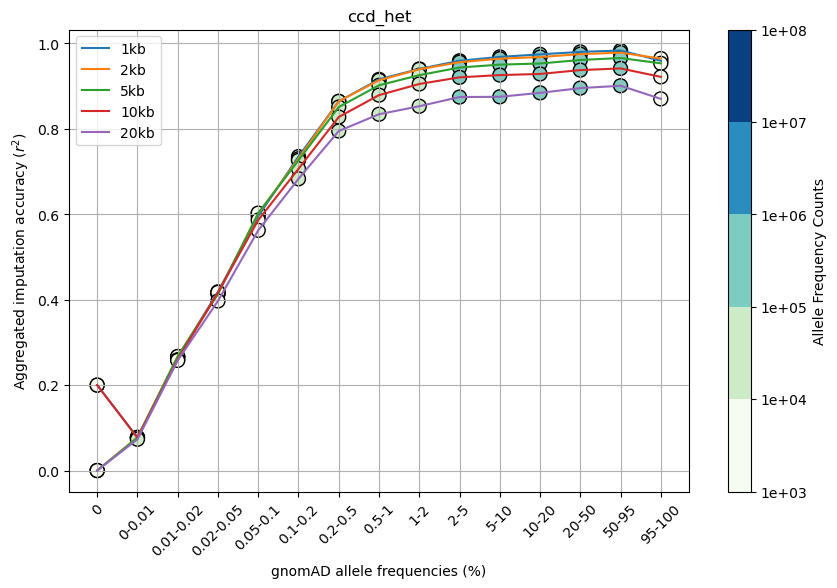

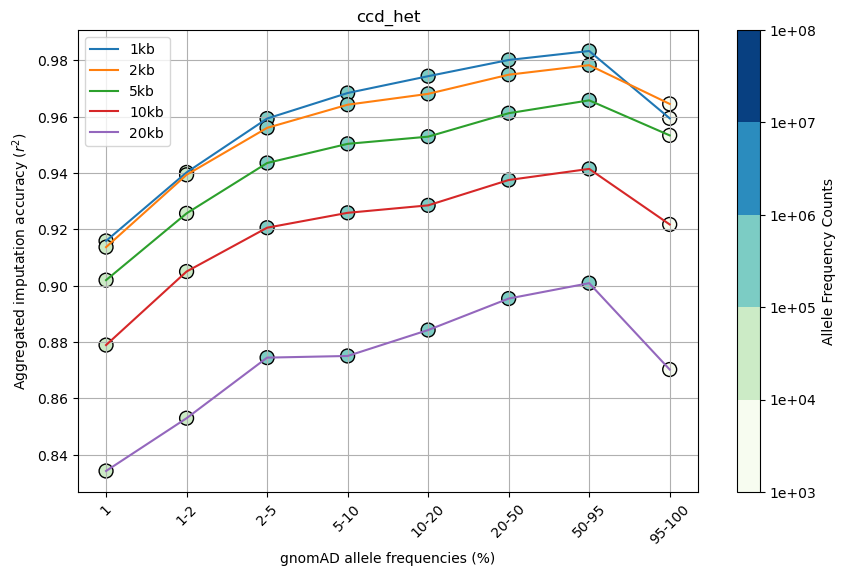

In [56]:
for i in lr_ary:
    if i.loc[0, 'ccd_homalt'] == -9:
        i.loc[0, 'ccd_homalt'] = 0
    if i.loc[0, 'ccd_het'] == -9:
        i.loc[0, 'ccd_het'] = 0
        
dfs = lr_ary
labels = lr_rls
metric = 'ccd_het'

lcwgsus.plot_imputation_accuracy_gw(dfs, metric = metric, labels = labels, title = metric)
lcwgsus.plot_imputation_accuracy_gw(dfs, metric = metric, threshold = 0.01, labels = labels, title = metric)

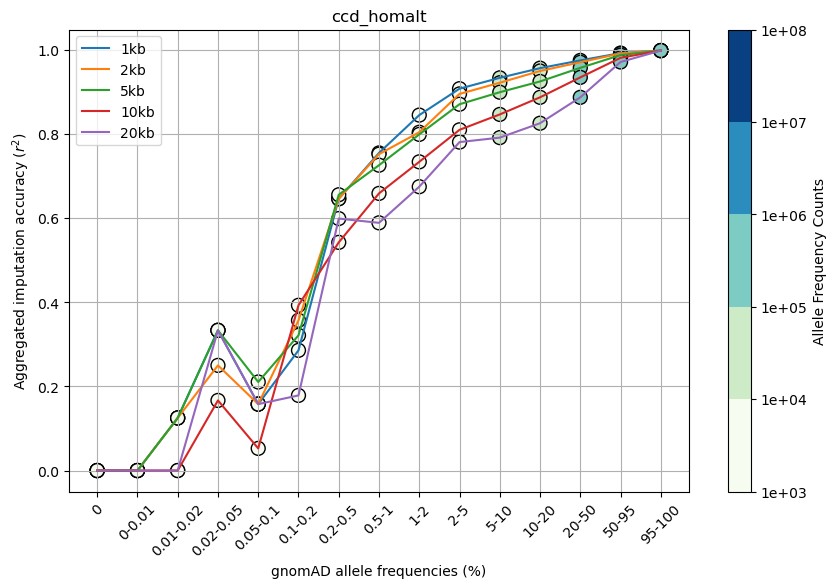

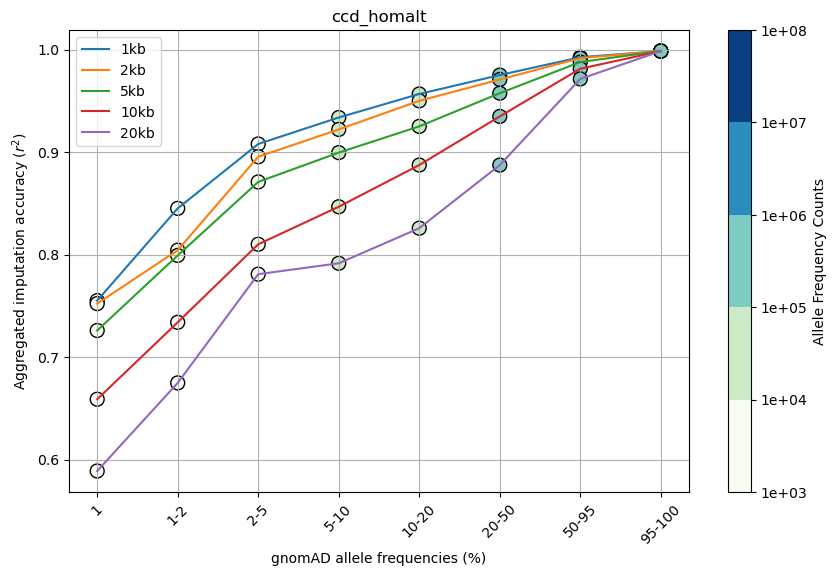

In [57]:
for i in lr_ary:
    if i.loc[0, 'ccd_homalt'] == -9:
        i.loc[0, 'ccd_homalt'] = 0
    if i.loc[0, 'ccd_het'] == -9:
        i.loc[0, 'ccd_het'] = 0
        
dfs = lr_ary
labels = lr_rls
metric = 'ccd_homalt'

lcwgsus.plot_imputation_accuracy_gw(dfs, metric = metric, labels = labels, title = metric)
lcwgsus.plot_imputation_accuracy_gw(dfs, metric = metric, threshold = 0.01, labels = labels, title = metric)

# Plot short-read simulation

In [5]:
sr_rls = ["151-long", "151-optimal", "151-real", "151-short", "300-long", "300-optimal", "300-real", "300-short"]

chrs = [pd.read_csv("/well/band/users/rbx225/GAMCC/results/imputation_comparison/sr_simulation/lc_oneKG--hc--snps_gw/impacc/all_samples/by_sample/chr" + i + ".v.tsv", sep = '\t') for i in CHROMOSOMES_ALL]
chrs[0]

sr_ary = []
for r in sr_rls:
    sr_impaccs = []
    for df in chrs:
        sr_impaccs.append(df[df['sample'] == r].drop(columns = 'sample'))
    sr_ary.append(lcwgsus.average_impacc_by_chr(sr_impaccs))

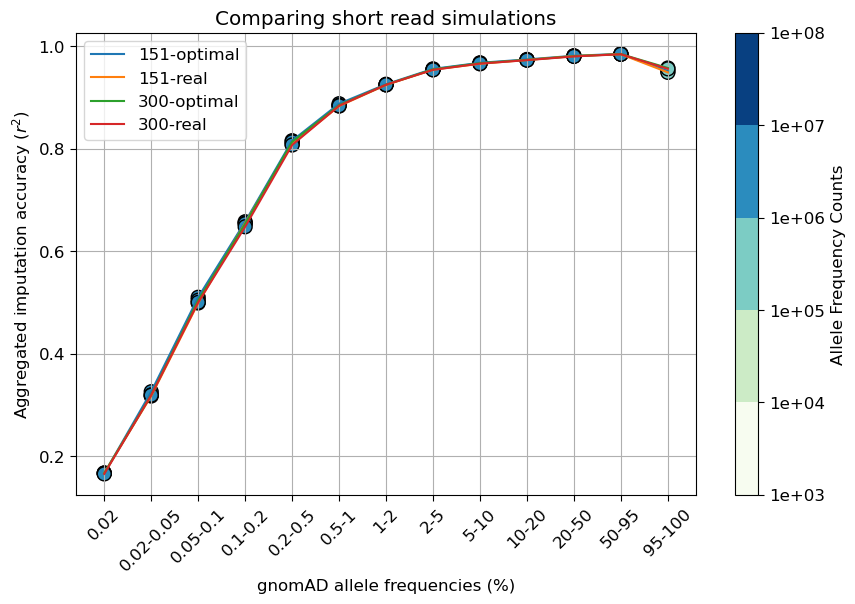

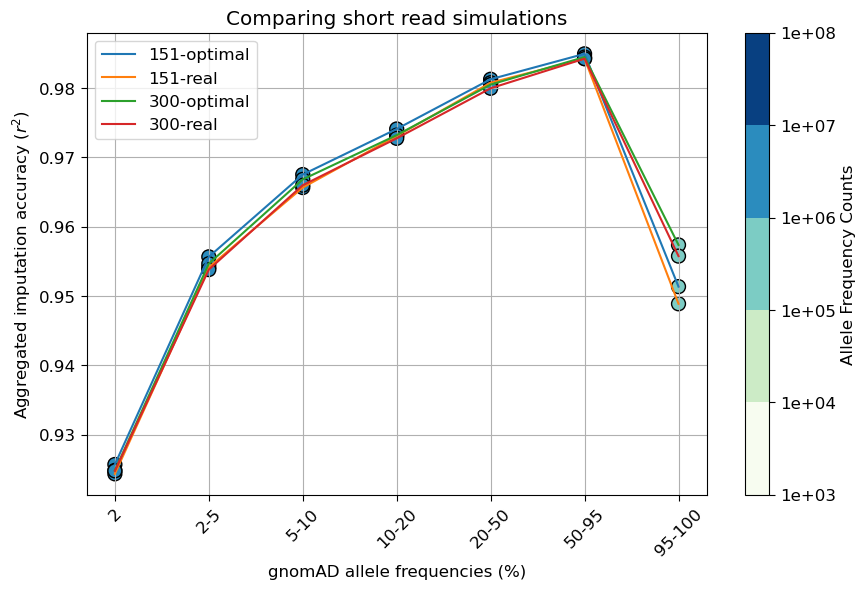

In [7]:
ixs = [1,2,5,6]
dfs = [sr_ary[i] for i in ixs]
labels = [sr_rls[i] for i in ixs]
title = 'Comparing short read simulations'

lcwgsus.plot_imputation_accuracy_gw(dfs, labels = labels, threshold = 0.0002, title = title)
lcwgsus.plot_imputation_accuracy_gw(dfs, labels = labels, threshold = 0.02, title = title)

In [8]:
dfs = sr_ary + [sr_vanilla, lr_ary[0]]
labels = sr_rls + ['151', lr_rls[0]]
title = 'Comparing long/short read results'

lcwgsus.plot_imputation_accuracy_gw(dfs, labels = labels, title = title)
lcwgsus.plot_imputation_accuracy_gw(dfs, labels = labels, threshold = 0.01, title = title)

NameError: name 'sr_vanilla' is not defined

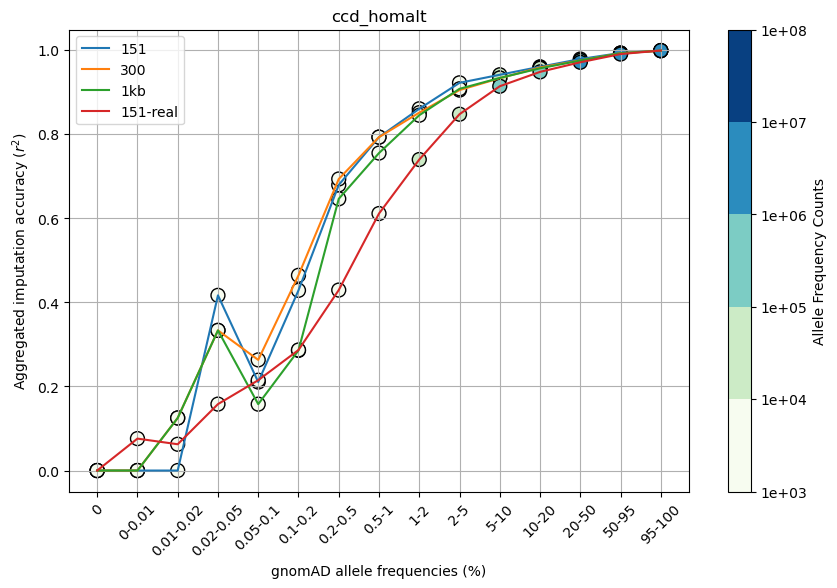

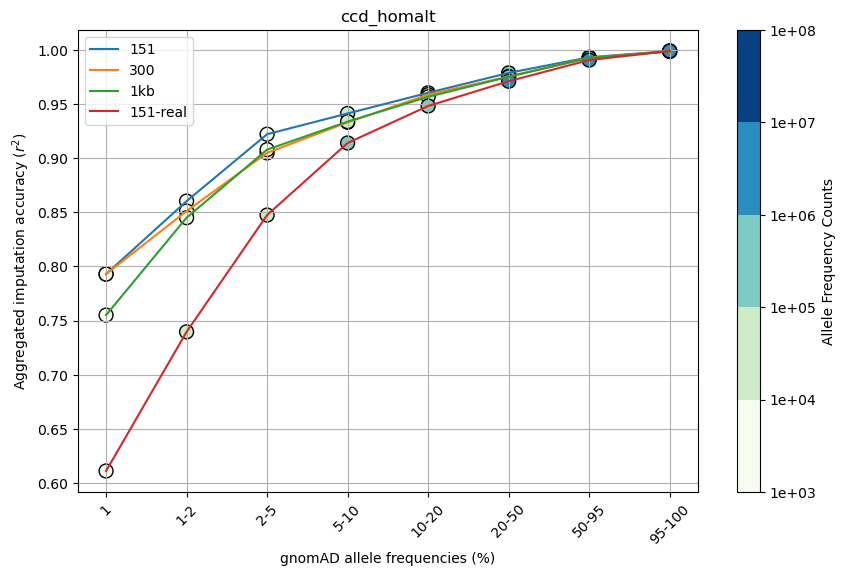

In [54]:
metric = 'ccd_homalt'


lr_ary[0].loc[0, metric] = 0
sr_ary[0].loc[0, metric] = 0
sr_ary[1].loc[0, metric] = 0

dfs = sr_ary + [lr_ary[0], sr_vanilla]
labels = sr_rls + ['1kb', '151-real']

lcwgsus.plot_imputation_accuracy_gw(dfs, metric =  metric, labels = labels, title = metric)
lcwgsus.plot_imputation_accuracy_gw(dfs, metric = metric, threshold = 0.01, labels = labels, title = metric)

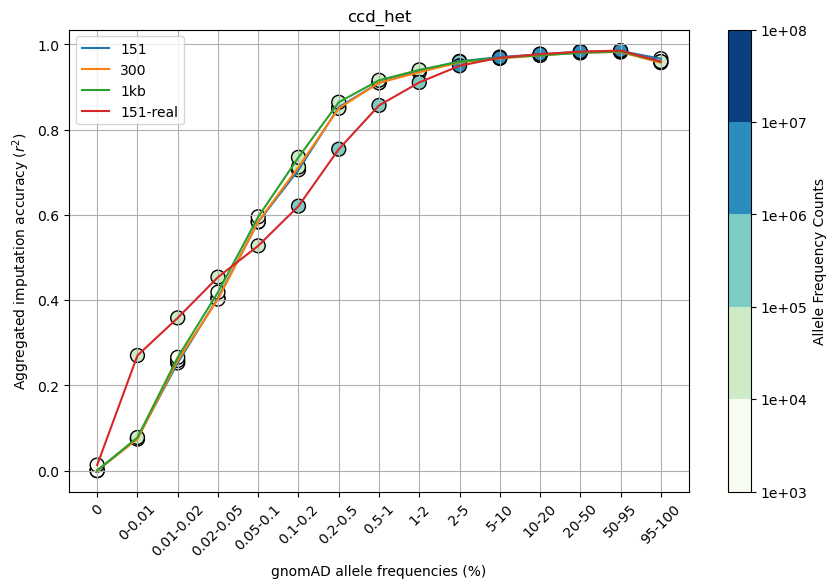

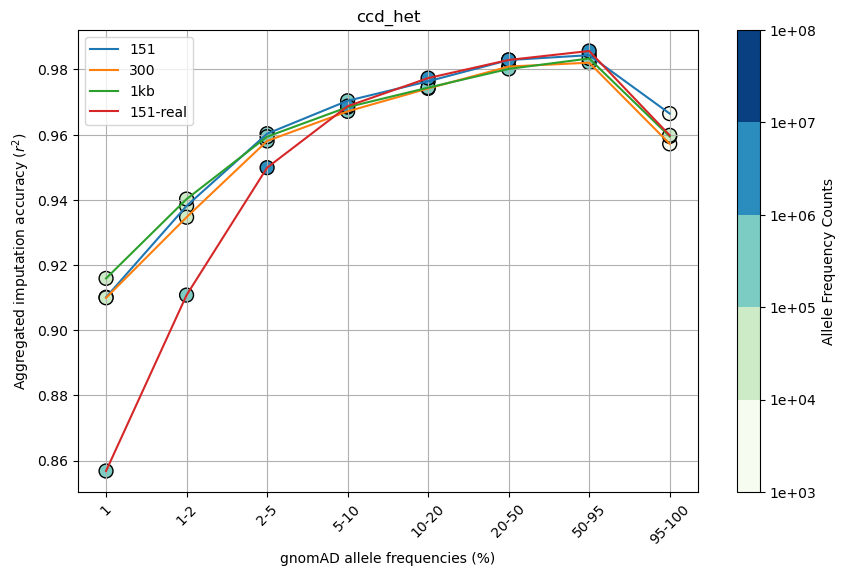

In [47]:
metric = 'ccd_het'

lr_ary[0].loc[0, metric] = 0
sr_ary[1].loc[0, metric] = 0
dfs = sr_ary + [lr_ary[0], sr_vanilla]
labels = sr_rls + ['1kb', '151-real']

lcwgsus.plot_imputation_accuracy_gw(dfs, metric =  metric, labels = labels, title = metric)
lcwgsus.plot_imputation_accuracy_gw(dfs, metric = metric, threshold = 0.01, labels = labels, title = metric)

# Plot chip-typed variants by cc and eth

In [114]:
configfile = "/well/band/users/rbx225/GAMCC/pipelines/config.json"
with open(configfile, 'r') as file:
    data = json.load(file)
imp_dirs = data['imputation_dir'][1]

case_controls = ['non-malaria_control', 'mild_malaria', 'severe_malaria']
ethnicities = ['fula', 'jola', 'mandinka', 'wollof']

mini = False
common_cols = ['chr', 'pos', 'ref', 'alt']
lc_sample_prefix = 'GM'
chip_sample_prefix = 'GAM'
seq_sample_prefix = 'IDT'
imp_dir = imp_dirs

sample_linker='data/metadata/sample_linker.csv'
# sample_linker = pd.read_csv(sample_linker)

chromosomes = [str(i) for i in range(1,23)]
impaccs = []

d = "/well/band/users/rbx225/GAMCC/results/imputation_comparison/oneKG/lc_chip_typed_high_info/impacc/by_eth/by_sample/"

for e in ethnicities:
    v_lst = [d + e + ".chr" + i + ".v.impacc.tsv" for i in chromosomes]
    v_dfs = [pd.read_csv(i, sep = '\t') for i in v_lst]
    v = lcwgsus.average_impacc_by_chr(v_dfs)
    impaccs.append(v)

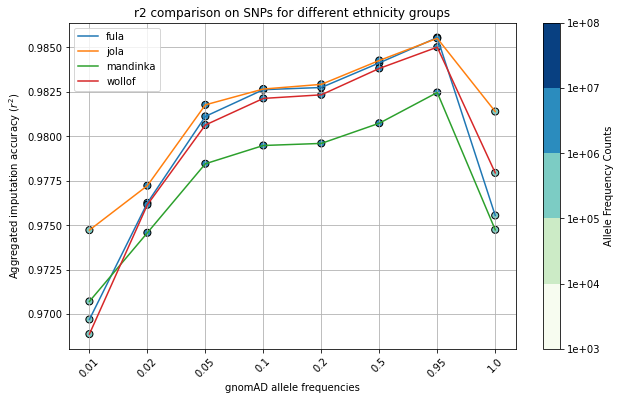

In [119]:
labels = ethnicities
dfs = [df[['AF', 'r2', 'r2_AC']] for df in impaccs]
t = 0.01
title = 'r2 comparison on SNPs for different ethnicity groups'

plt.figure(figsize=(10, 6))
ax = plt.subplot(1, 1, 1)
plt.grid(False)

cmap = plt.get_cmap('GnBu')
magnitude = 5
bounds = np.logspace(3, 8, magnitude+1)
norm = mcolors.BoundaryNorm(bounds, cmap.N)
fmt = lambda x, pos: '{:.0e}'.format(x)

for i in range(len(dfs)):
    triplet = dfs[i][dfs[i]['AF'] >= t]
    c0, c1, c2 = tuple(list(triplet.columns))

    label = c1 if labels is None else labels[i]

    x = np.arange(triplet.shape[0])
    afs = triplet[c0]
    vals = triplet[c1]
    color = triplet[c2]

    plt.plot(x, vals, label = label)
    plt.xticks(x, afs, rotation = 45)

    im = ax.scatter(x, vals, c=color, edgecolor='black', cmap=cmap, norm=norm, s = 50)
plt.colorbar(im, boundaries=bounds, ticks = bounds, format=FuncFormatter(fmt), label='Allele Frequency Counts')

plt.xlabel('gnomAD allele frequencies')
plt.title(title)
plt.legend()
plt.ylabel('Aggregated imputation accuracy ($r^2$)')
ax = plt.gca()
ax.grid()

In [120]:
configfile = "/well/band/users/rbx225/GAMCC/pipelines/config.json"
with open(configfile, 'r') as file:
    data = json.load(file)
imp_dirs = data['imputation_dir'][1]

case_controls = ['non-malaria_control', 'mild_malaria', 'severe_malaria']
ethnicities = ['fula', 'jola', 'mandinka', 'wollof']

mini = False
common_cols = ['chr', 'pos', 'ref', 'alt']
lc_sample_prefix = 'GM'
chip_sample_prefix = 'GAM'
seq_sample_prefix = 'IDT'
imp_dir = imp_dirs

sample_linker='data/metadata/sample_linker.csv'
# sample_linker = pd.read_csv(sample_linker)

chromosomes = [str(i) for i in range(1,23)]
impaccs = []

d = "/well/band/users/rbx225/GAMCC/results/imputation_comparison/oneKG/lc_chip_typed_high_info/impacc/by_cc/by_sample/"

for c in case_controls:
    v_lst = [d + c + ".chr" + i + ".v.impacc.tsv" for i in chromosomes]
    v_dfs = [pd.read_csv(i, sep = '\t') for i in v_lst]
    v = lcwgsus.average_impacc_by_chr(v_dfs)
    impaccs.append(v)

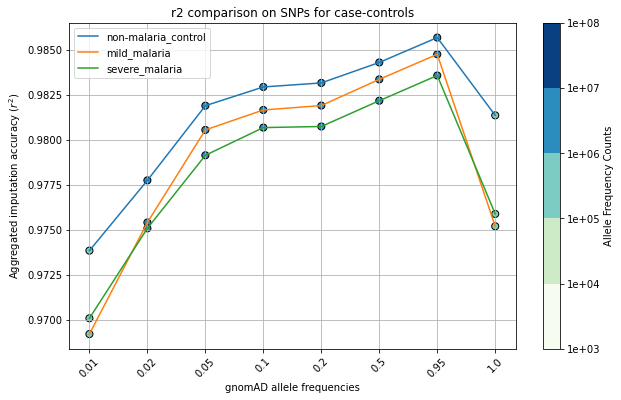

In [122]:
labels = case_controls
dfs = [df[['AF', 'r2', 'r2_AC']] for df in impaccs]
t = 0.01
title = 'r2 comparison on SNPs for case-controls'

plt.figure(figsize=(10, 6))
ax = plt.subplot(1, 1, 1)
plt.grid(False)

cmap = plt.get_cmap('GnBu')
magnitude = 5
bounds = np.logspace(3, 8, magnitude+1)
norm = mcolors.BoundaryNorm(bounds, cmap.N)
fmt = lambda x, pos: '{:.0e}'.format(x)

for i in range(len(dfs)):
    triplet = dfs[i][dfs[i]['AF'] >= t]
    c0, c1, c2 = tuple(list(triplet.columns))

    label = c1 if labels is None else labels[i]

    x = np.arange(triplet.shape[0])
    afs = triplet[c0]
    vals = triplet[c1]
    color = triplet[c2]

    plt.plot(x, vals, label = label)
    plt.xticks(x, afs, rotation = 45)

    im = ax.scatter(x, vals, c=color, edgecolor='black', cmap=cmap, norm=norm, s = 50)
plt.colorbar(im, boundaries=bounds, ticks = bounds, format=FuncFormatter(fmt), label='Allele Frequency Counts')

plt.xlabel('gnomAD allele frequencies')
plt.title(title)
plt.legend()
plt.ylabel('Aggregated imputation accuracy ($r^2$)')
ax = plt.gca()
ax.grid()

# GWAS catalog

In [ ]:
gwassnps = pd.read_csv("/well/band/users/rbx225/recyclable_files/bedgraph/gwas_snps.tsv", sep = '\t', header = None, names = ['chr', 'pos', 'ID']).drop(columns = 'ID')
gwassnps = gwassnps[(~gwassnps['chr'].str.contains('alt')) & (~gwassnps['chr'].str.contains('X')) & (~gwassnps['chr'].str.contains('Y'))& (~gwassnps['chr'].str.contains('random'))]
gwassnps['chr'] = gwassnps['chr'].str.split('chr').str.get(1).astype(int)
gwassnps = gwassnps.sort_values(by = 'chr', ascending = True).reset_index(drop = True)

In [ ]:
runs = ['lc_oneKG--chip--typed', 'lc_oneKG--hc--snps_gw', 'lc_oneKG_topmed--hc--snps_gw']
impaccs = []

for r in runs:
    h = [pd.read_csv('results/imputation_comparison/vanilla/' + r + '/impacc/all_samples/by_variant/chr' + str(i) + '.h.tsv', sep = '\t') for i in CHROMOSOMES_ALL]
    h = pd.concat(h)
    h = h[h['r2'] != -9]
    gwas = pd.merge(h, gwassnps, on = ['chr', 'pos'])
    h_impacc = lcwgsus.generate_h_impacc(gwas)
    impaccs.append(h_impacc)

In [ ]:
impaccs[0].loc[[0,2], 'r2'] = 0
impaccs[1].loc[0, 'r2'] = 0
impaccs[2].loc[0, 'r2'] = 0

dfs = impaccs
labels = ['lc-chip', 'lc-1KG', 'lc-1KG-TOPMed']
title = 'GWAS catalog r2'

lcwgsus.plot_imputation_accuracy_gw(dfs, labels = labels, title = title)
lcwgsus.plot_imputation_accuracy_gw(dfs, labels = labels, threshold = 0.01, title = title)

# Imputation accuracy at different regions

## HLA region

In [9]:
# See this url for a documentation on more information on the array https://www.thermofisher.com/document-connect/document-connect.html?url=https://assets.thermofisher.com/TFS-Assets%2FLSG%2Fbrochures%2FGGNO07706-2_DS_Axiom_PMRA.pdf

db = sqlite3.connect("data/chip/Axiom_PMRA.na36.r1.a1.annot.db")
X = pd.read_sql_query("SELECT * FROM Annotations", db)
X['Associated_Gene'] = X['Associated_Gene'].str.split(' // ').str.get(-1)
X['Heterozygous_Allele_Frequencies'] = X['Heterozygous_Allele_Frequencies'].str.split(' /// ').str.get(-1).str.split(' // ').str.get(0)
X['Minor_Allele_Frequency'] = X['Minor_Allele_Frequency'].str.split(' /// ').str.get(-1).str.split(' // ').str.get(0)
X = X.drop(columns = ['ProbeSet_ID', 'Affy_SNP_ID', 'Strand', 'Stop',
                      'dbSNP_Loctype', 'In_Hapmap', 'Strand_Vs_dbSNP', 'Probe_Count',
                     'ChrX_PAR', 'Cytoband', 'Flank', 'Allele_A', 'Allele_B', 'Genetic_Map',
                     'Microsatellite', 'Allele_Frequency_Count', 'ClinVar_OMIM_Phenotype',
                     'ClinVar_OMIM_Description', 'ClinVar_MIM', 'EBI_PUBMEDID',
                     'EBI_MAPPED_GENE', 'EBI_SNPS', 'EBI_SNP_ID_CURRENT', 'EBI_MAPPED_TRAIT',
                     'EBI_MAPPED_TRAIT_URI', 'Allele_Frequencies', 'Minor_Allele', 'Ordered_Alleles',
                     'Annotation_Notes', 'extended_rsid', 'ClinVar_VariantID', 'Biomedical', 'ClinVar_RSID'])
X = X.rename(columns = {'Chr_id': 'chr', 'Start': 'pos', 'dbSNP_RS_ID': 'ID', 'Ref_Allele': 'ref', 'Alt_Allele': 'alt'})
X = X[X['chr'].astype(str).isin(CHROMOSOMES_ALL)]
X = X.sort_values(by = ['chr', 'pos'], ascending = True)
clin_cols = ['OMIM', 'ClinVar_ClinicalSignificance', 'ClinVar_GeneSymbol', 'ClinVar_Traits', 'ClinVar_OMIM_Gene']
for i in clin_cols:
    X[i] = X[i].astype(str)

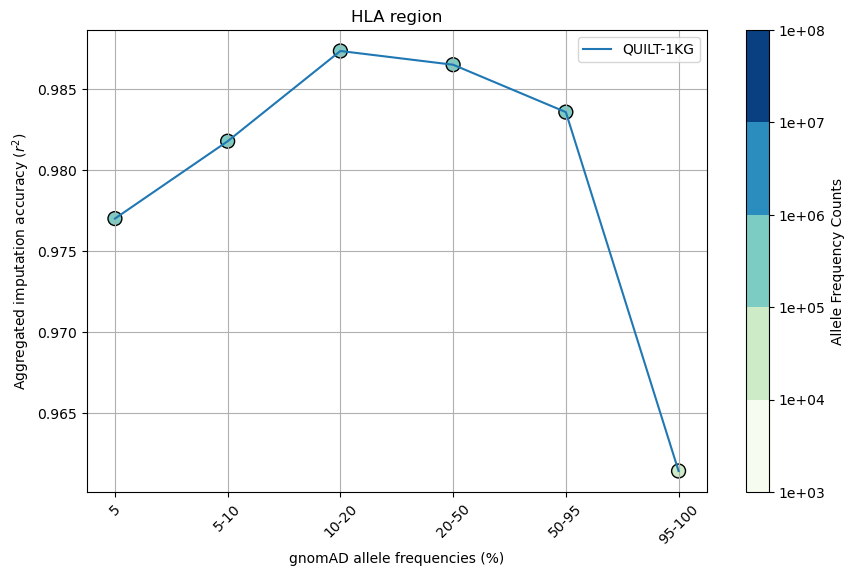

In [10]:
hla = X[(X['chr'] == 6) & (X['pos'] < 33965553) & (X['pos'] > 27970031)].reset_index(drop = True)

c6 = pd.read_csv('results/imputation_comparison/vanilla/lc_oneKG--chip--typed/impacc/all_samples/by_variant/chr6.h.tsv', sep = '\t')
merged = pd.merge(hla, c6, on = COMMON_COLS).drop_duplicates()
h_impacc = lcwgsus.generate_h_impacc(merged)

dfs = [h_impacc]
labels = ['QUILT-1KG']
title = 'HLA region'

# lcwgsus.plot_imputation_accuracy_gw(dfs, labels = labels, title = title)
lcwgsus.plot_imputation_accuracy_gw(dfs, labels = labels, threshold = 0.05, title = title)

## Blood Group Varaints

In [2]:
X = X[~X[clin_cols].eq("None").all(axis=1)]

bad = pd.read_csv('results/imputation_comparison/vanilla/lc_oneKG--chip--typed/impacc/all_samples/by_variant/all_r2less0.5.tsv', sep = '\t')
merged = pd.merge(X, bad, on = ['chr', 'pos']).drop_duplicates()
merged

keywords = ['anemia', 'blood', 'Eryth']
keywords = '|'.join(keywords)

Y = X[X['OMIM'].str.contains(keywords, case=False, na=False)]

chr         pos           ID ref alt  \
162238    1   1005429.0   rs58913475   -   A   
682670    1   1005721.0  rs114443588   G   T   
595637    1   1011483.0  rs183136696   A   C   
682671    1   1012429.0  rs115074115   G   C   
506500    1   1014143.0  rs786201005   C   T   
...     ...         ...          ...  ..  ..   
901812   22  50744726.0  rs762191835   G   -   
703609   22  50747104.0  rs115392965   C   T   
291819   22  50749396.0  rs141612488   C   T   
785709   22  50749854.0   rs28420908   G   A   
703610   22  50749890.0  rs117000254   T   G   

                               Associated_Gene  \
162238  hes family bHLH transcription factor 4   
682670  hes family bHLH transcription factor 4   
595637  hes family bHLH transcription factor 4   
682671  hes family bHLH transcription factor 4   
506500           ISG15 ubiquitin-like modifier   
...                                        ...   
901812                                 acrosin   
703609    ribosomal protein L23a pseudogene 82   
291819    ribosomal protein L23a pseudogene 82   
785709    ribosomal protein L23a pseudogene 82   
703610    ribosomal protein L23a pseudogene 82   

       Heterozygous_Allele_Frequencies Minor_Allele_Frequency  \
162238                          0.4722                 0.2731   
682670                          0.1852                 0.1111   
595637                          0.0556                 0.0278   
682671                          0.0000                 0.0000   
506500                            None                   None   
...                                ...                    ...   
901812                            None                   None   
703609                          0.1111                 0.0556   
291819                          0.2037                 0.1204   
785709                          0.1944                 0.0972   
703610                          0.0278                 0.0139   

                                                     OMIM  Allele_Count  \
162238  147571 // Immunodeficiency 38 // 616126 // int...           2.0   
682670  147571 // Immunodeficiency 38 // 616126 // int...           2.0   
595637  147571 // Immunodeficiency 38 // 616126 // int...           2.0   
682671  147571 // Immunodeficiency 38 // 616126 // int...           2.0   
506500  147571 // Immunodeficiency 38 // 616126 // non...           2.0   
...                                                   ...           ...   
901812  102480 // ?Male infertility due to acrosin def...           2.0   
703609  102480 // ?Male infertility due to acrosin def...           2.0   
291819  102480 // ?Male infertility due to acrosin def...           2.0   
785709  102480 // ?Male infertility due to acrosin def...           2.0   
703610  102480 // ?Male infertility due to acrosin def...           2.0   

       ClinVar_ClinicalSignificance ClinVar_GeneSymbol  \
162238                         None               None   
682670                         None               None   
595637                         None               None   
682671                         None               None   
506500                   PATHOGENIC              ISG15   
...                             ...                ...   
901812                         None               None   
703609                         None               None   
291819                         None               None   
785709                         None               None   
703610                         None               None   

                                           ClinVar_Traits ClinVar_OMIM_Gene  \
162238                                               None              None   
682670                                               None              None   
595637                                               None              None   
682671                                               None              None   
506500  IMMUNODEFICIENCY 38 WITH BASAL GANGLIA CALCIFI..

In [4]:
runs = ['lc_oneKG--chip--typed', 'lc_oneKG--hc--snps_gw', 'lc_oneKG_topmed--hc--snps_gw']
impaccs = []

for r in runs:
    h = [pd.read_csv('results/imputation_comparison/vanilla/' + r + '/impacc/all_samples/by_variant/chr' + str(i) + '.h.tsv', sep = '\t') for i in CHROMOSOMES_ALL]
    h = pd.concat(h)
    h = h[h['r2'] != -9]
    gwas = pd.merge(h, Y, on = ['chr', 'pos'])
    h_impacc = lcwgsus.generate_h_impacc(gwas)
    impaccs.append(h_impacc)

KeyboardInterrupt: 

In [ ]:
# impaccs[0].loc[[0,2], 'r2'] = 0
# impaccs[1].loc[0, 'r2'] = 0
# impaccs[2].loc[0, 'r2'] = 0

dfs = impaccs
labels = ['lc-chip', 'lc-1KG', 'lc-1KG-TOPMed']
title = 'Blood group variants r2'

# lcwgsus.plot_imputation_accuracy_gw(dfs, labels = labels, title = title)
lcwgsus.plot_imputation_accuracy_gw(dfs, labels = labels, threshold = 0.01, title = title)

## Various Categories

In [ ]:
clin_cols = ['OMIM', 'ClinVar_ClinicalSignificance', 'ClinVar_GeneSymbol', 'ClinVar_Traits', 'ClinVar_OMIM_Gene']

def absolute_numbers(val):
    absolute = int(val / 100. * counts.sum())
    return f'{absolute}'

for i in clin_cols:
    counts = merged[merged[i] != 'None'][i].value_counts()
    plt.figure(figsize=(8, 6))
    counts.plot.pie(autopct=absolute_numbers, startangle=90, counterclock=False)
    plt.ylabel('')  # Hide the y-label
    plt.title(i)
    plt.show()

## Worst imputed region

In [5]:
hs = []
for i in CHROMOSOMES_ALL:
    t = pd.read_csv('results/imputation_comparison/vanilla/lc_oneKG--chip--typed/impacc/all_samples/by_variant/chr' + str(i) + '.h.tsv', sep = '\t')
    hs.append(t)
h = pd.concat(hs)

chr       pos ref alt       MAF       NRC  NRC_BC        r2  r2_BC  \
0        1    784860   T   C  0.959400  1.000000     183  0.997843    185   
1        1    785910   G   C  0.025452  0.750000       8  0.842741    184   
2        1    788538   G   A  0.086260  0.973684      38  0.971634    186   
3        1    818725   C   T  0.023735  0.875000       8  0.853221    185   
4        1    819249   A   G  0.025074  0.875000       8  0.857605    186   
...    ...       ...  ..  ..       ...       ...     ...       ...    ...   
12132   22  50749854   G   A  0.093138  0.956522      23  0.983148    186   
12133   22  50749890   T   G  0.025043  1.000000       5  0.999999    185   
12134   22  50770140   G   T  0.261949  0.958763      97  0.950049    186   
12135   22  50777904   G   A  0.041119  0.944444      18  0.974504    185   
12136   22  50779526   G   A  0.088980  1.000000      17  1.000000    186   

       ccd_homref  ccd_homref_BC   ccd_het  ccd_het_BC  ccd_homalt  \
0        1.000000              2  1.000000          20         1.0   
1        1.000000            176  0.750000           8        -9.0   
2        1.000000            148  0.970588          34         1.0   
3        1.000000            177  0.875000           8        -9.0   
4        1.000000            178  0.875000           8        -9.0   
...           ...            ...       ...         ...         ...   
12132    1.000000            163  0.952381          21         1.0   
12133    1.000000            180  1.000000           5        -9.0   
12134    0.967391             92  0.987805          82         1.0   
12135    0.994048            168  1.000000          17        -9.0   
12136    1.000000            169  1.000000          14         1.0   

       ccd_homalt_BC  
0                163  
1                  0  
2                  4  
3                  0  
4                  0  
...              ...  
12132              2  
12133              0  
12134             12  
12135              0  
12136              3  

[708100 rows x 15 columns]

In [20]:
window = 1e5
means = []
for snp in range(len(merged)):
    means.append(lcwgsus.plot_imputation_metric_in_region(h, merged.iloc[snp, 0], merged.iloc[snp, 1], window = window, show_fig = False))
means = np.array(means)
np.argsort(means)

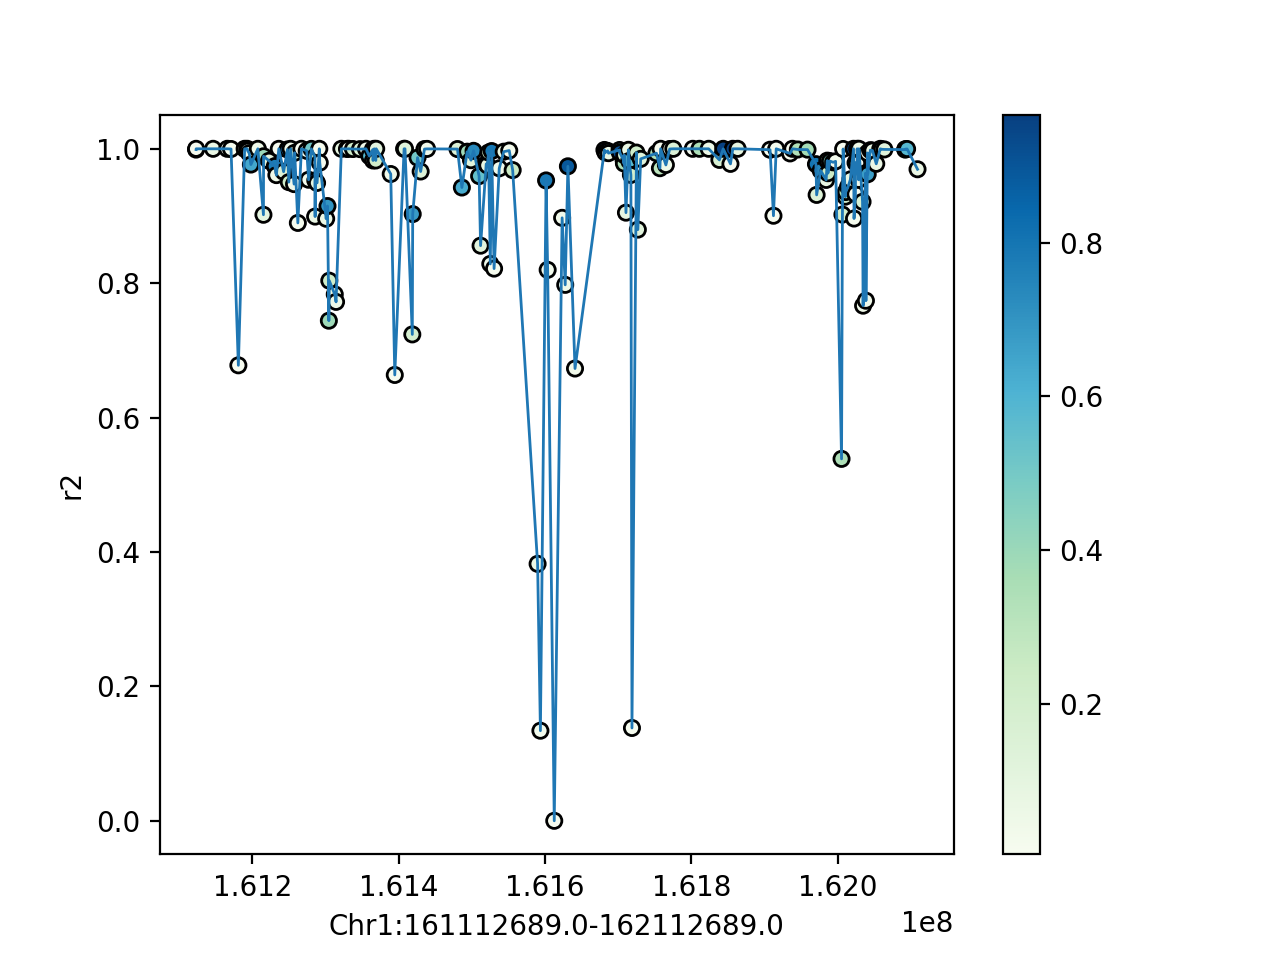

0.9370350800849158

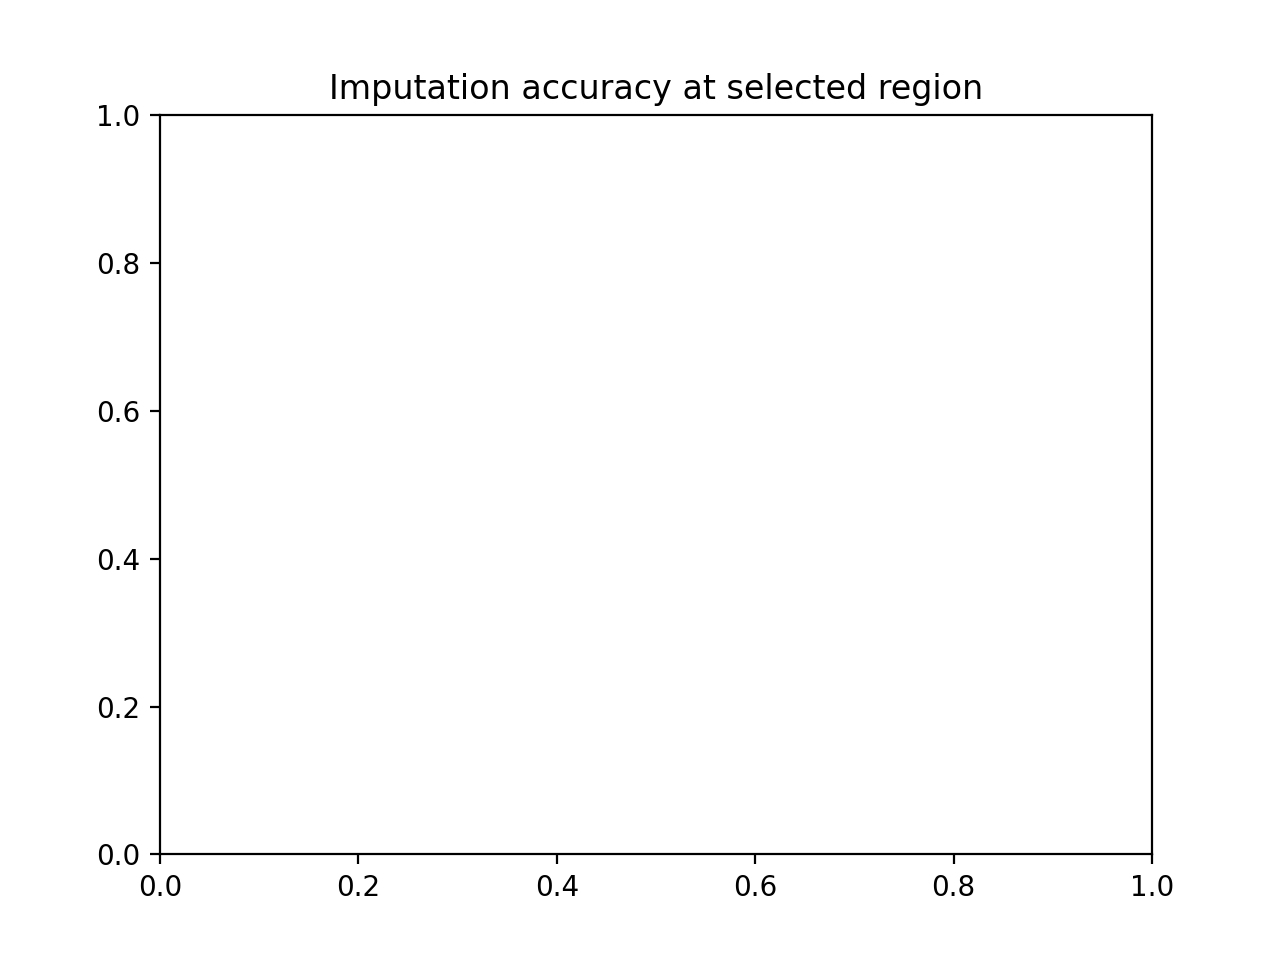

In [28]:
lcwgsus.plot_imputation_metric_in_region(h, merged.iloc[58, 0], merged.iloc[58, 1], window = 1e6, show_fig = True)

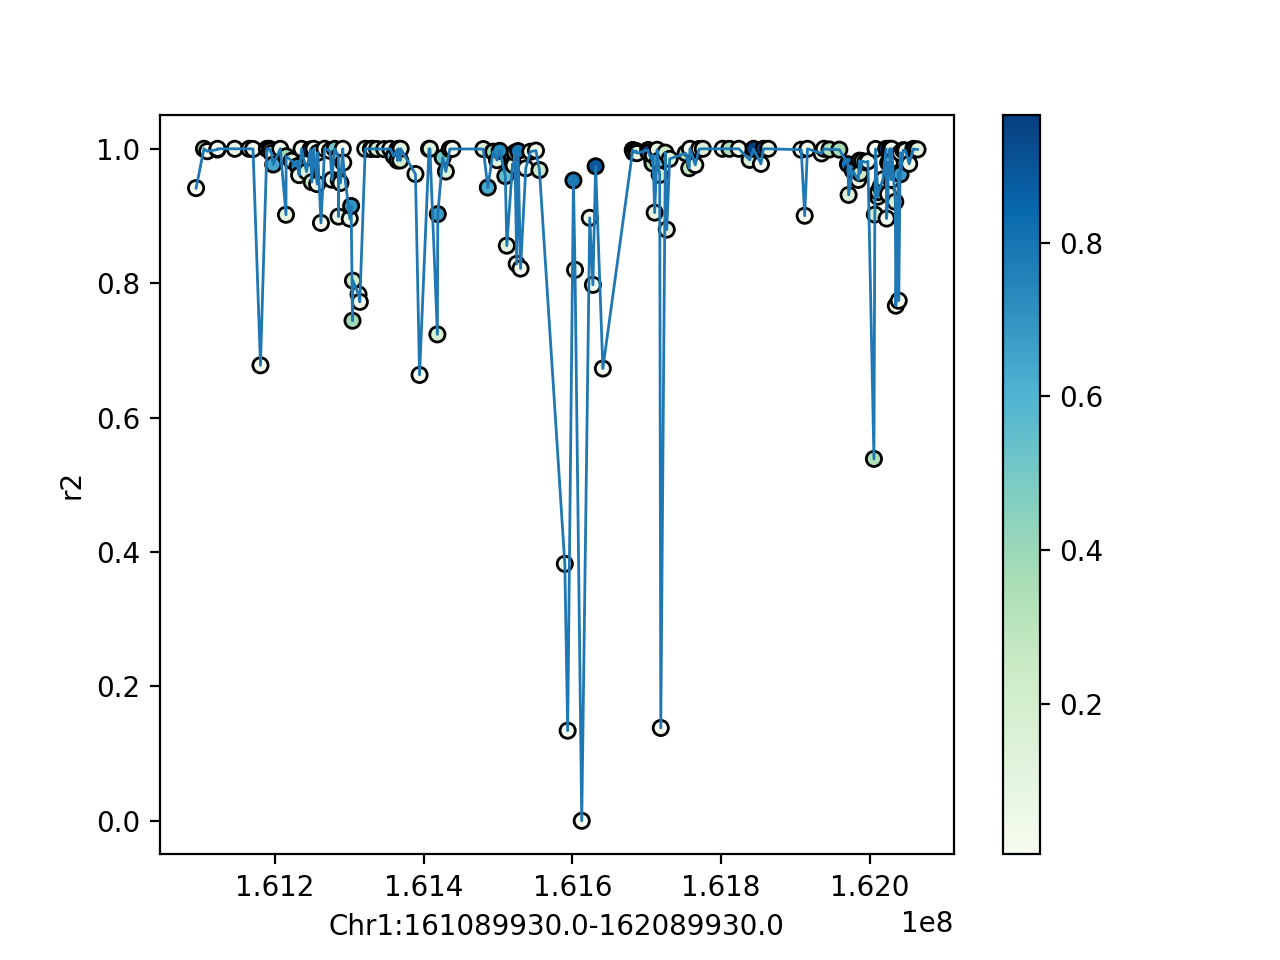

0.9364802742979811

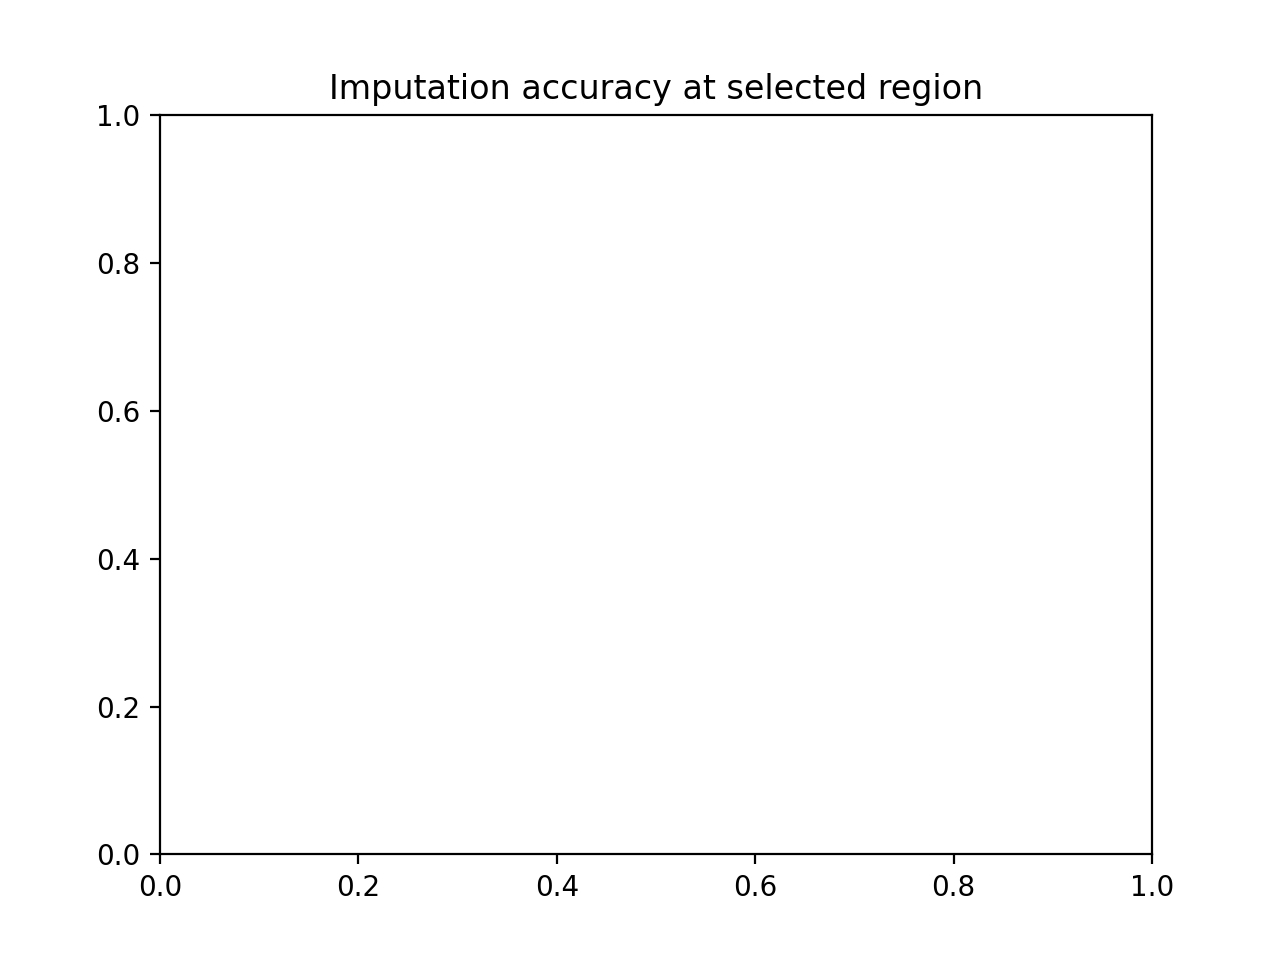

In [30]:
lcwgsus.plot_imputation_metric_in_region(h, merged.iloc[56, 0], merged.iloc[56, 1], window = 1e6, show_fig = True)

# HLA Diversity

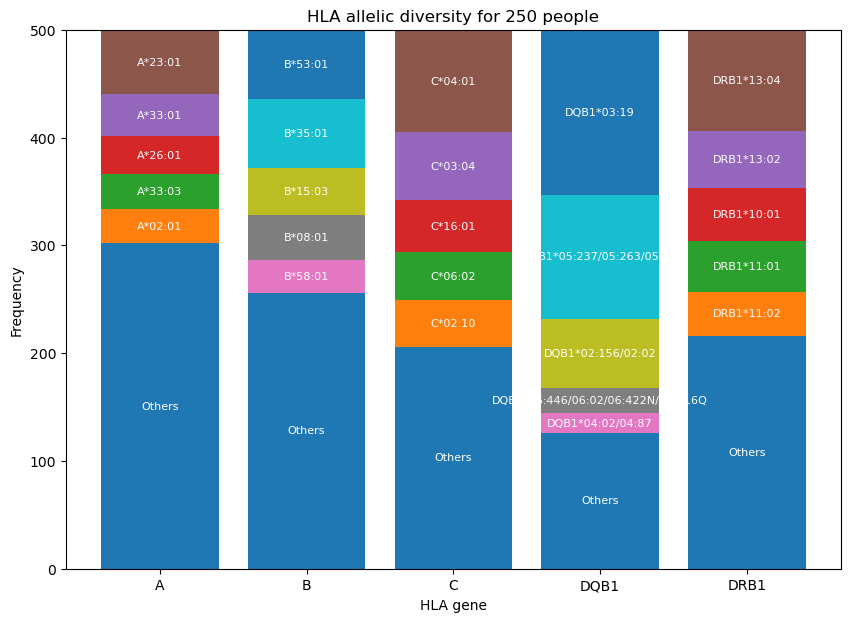

Gene  Shannon Entropy  Number of distinct alleles  \
0     A         2.936754                          25   
1     B         3.103069                          42   
2     C         2.694756                          25   
3  DQB1         2.228746                          23   
4  DRB1         2.741211                          31   

   Number of ambiguous type from SBT  
0                                  0  
1                                  0  
2                                  0  
3                                294  
4                                 90

In [2]:
hla = lcwgsus.read_hla_direct_sequencing()
hla_alleles_df = lcwgsus.gather_hla_alleles(hla)
lcwgsus.plot_hla_diversity(hla_alleles_df)
summary = lcwgsus.calculate_hla_entropy(hla_alleles_df)
summary

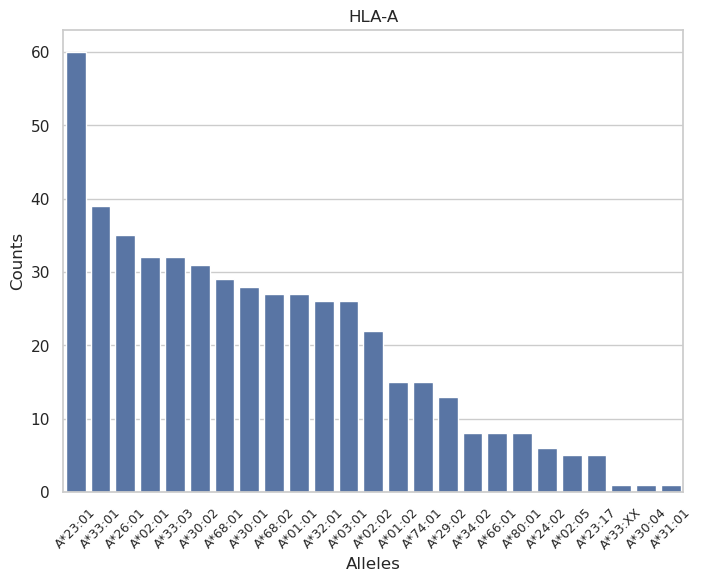

In [3]:
lcwgsus.plot_HLA_allele_frequency(hla_alleles_df, 'A')

# HLA imputation accuracy

In [27]:
hla = lcwgsus.read_hla_direct_sequencing(retain = 'fv')

# hla_dirs = ['/well/band/users/rbx225/GAMCC/results/hla/imputation/batches/', 
#                   '/well/band/users/rbx225/GAMCC/results/hla/server/chip_vanilla/chr6.dose.vcf.gz',
#                  '/well/band/users/rbx225/GAMCC/results/hla/server/lc_oneKG/chr6.dose.vcf.gz',
#            '/well/band/users/rbx225/GAMCC/results/hla/server/lc_oneKG_typed/chr6.dose.vcf.gz']
# labels =  ['QUILT', 'chip_multiEth', 'QUILT_multiEth', 'QUILT_typed_multiEth']

hla_dirs = ['/well/band/users/rbx225/GAMCC/results/hla/imputation/batches_archived/', 
                  '/well/band/users/rbx225/GAMCC/results/hla/server/chip_vanilla/chr6.dose.vcf.gz',
                  '/well/band/users/rbx225/GAMCC/results/hla/server/lc_oneKG/chr6.dose.vcf.gz',
                  '/well/band/users/rbx225/GAMCC/results/hla/server/lc_oneKG_strict/chr6.dose.vcf.gz',
                  '/well/band/users/rbx225/GAMCC/results/hla/server/lc_mGenv1/chr6.dose.vcf.gz',
                  '/well/band/users/rbx225/GAMCC/results/hla/server/lc_mGenv3/chr6.dose.vcf.gz']
labels =  ['QUILT', 'chip_multiEth', '1KG_multiEth', '1KG_strict_multiEth', 'mGenv1', 'mGenv3']

def plot_hla_imputation_accuracy(hla_dirs, labels, indices = None, cmap = 'tab20', save_fig=False, outdir=None, save_name=None):
    hla_reports = []
    
    colors = plt.get_cmap(cmap).colors[:(len(labels))]
    hex_codes = [mcolors.to_hex(color) for color in colors]
    colors = dict(zip(labels, hex_codes))
    
    if indices is not None:
        hla_dirs = [hla_dirs[i] for i in indices]
        labels = [labels[i] for i in indices]
        
    for d, l in zip(hla_dirs, labels):
        report = lcwgsus.calculate_hla_imputation_accuracy(d, hla, l)
        hla_reports.append(report)
    report = pd.concat(hla_reports)
    report['Locus'] = pd.Categorical(report['Locus'], categories=HLA_GENES[::-1], ordered=True)
    report = report.sort_values(by = 'Locus')
        
    onefield = report[report['Resolution'] == 'One field']
    plot1 = (
        ggplot(onefield, aes(x='Concordance', y='Locus', color='Source')) +
        geom_point(size=2) + ggtitle('One Field') + theme_minimal() +
        scale_color_manual(values=colors) +
        theme(axis_text_y=element_text(angle=0), title=element_text(hjust='1'))
    )
    twofield = report[report['Resolution'] == 'Two field']
    plot2 = (
        ggplot(twofield, aes(x='Concordance', y='Locus', color='Source')) +
        geom_point(size=2) + ggtitle('Two Field') +
        scale_color_manual(values=colors) +
#         labs(x='Concordance', y='Locus', color='Source') + 
        theme_minimal() +
        theme(axis_text_y=element_text(angle=0), title=element_text(hjust=2))
    )
    p1 = pw.load_ggplot(plot1, figsize=(4,4))
    p2 = pw.load_ggplot(plot2, figsize=(4,4))
    p12 = (p1|p2)
    return p12

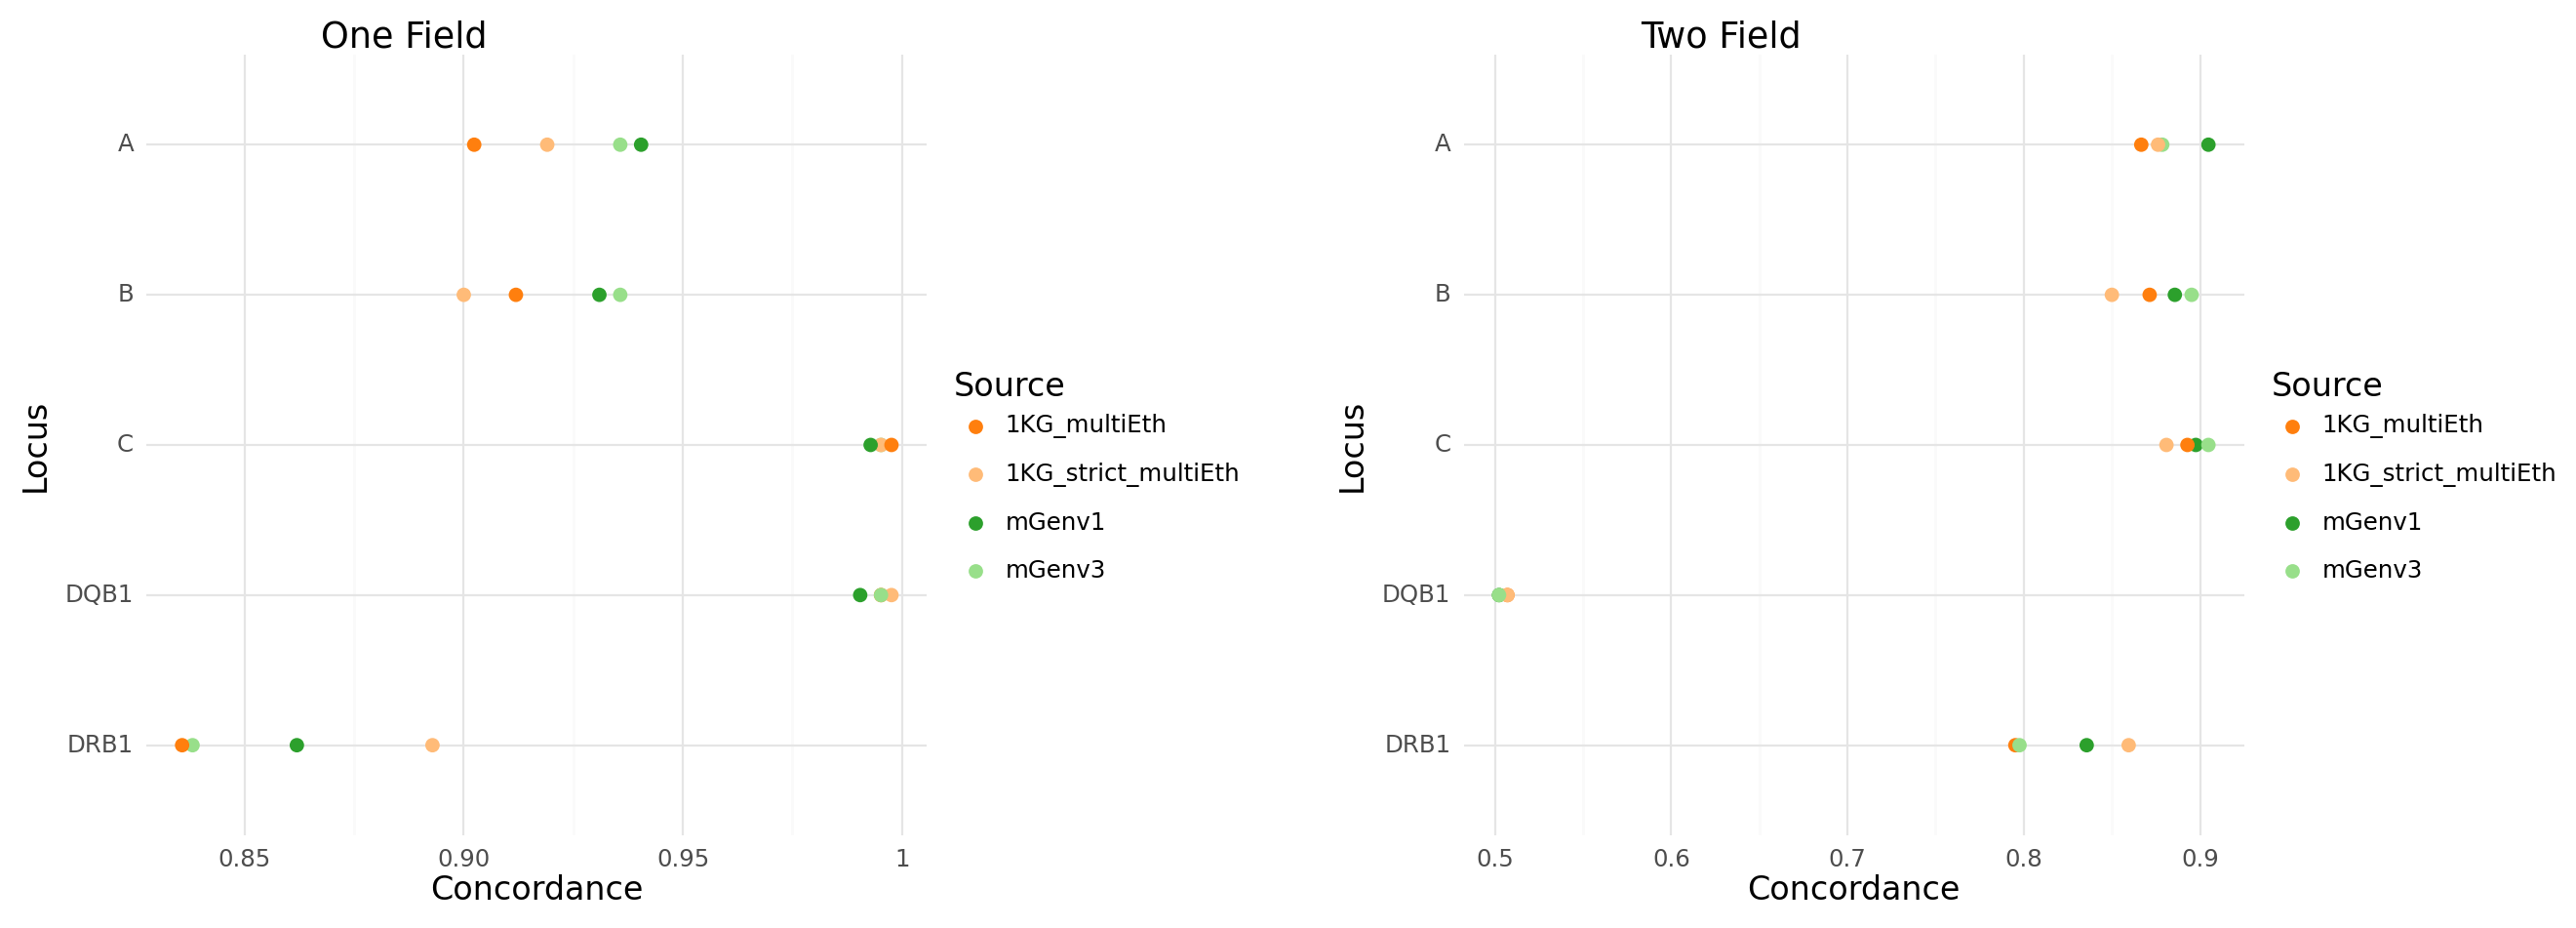

In [31]:
ixs = [2,3,4,5]
p = plot_hla_imputation_accuracy(hla_dirs, labels, indices = ixs)
p

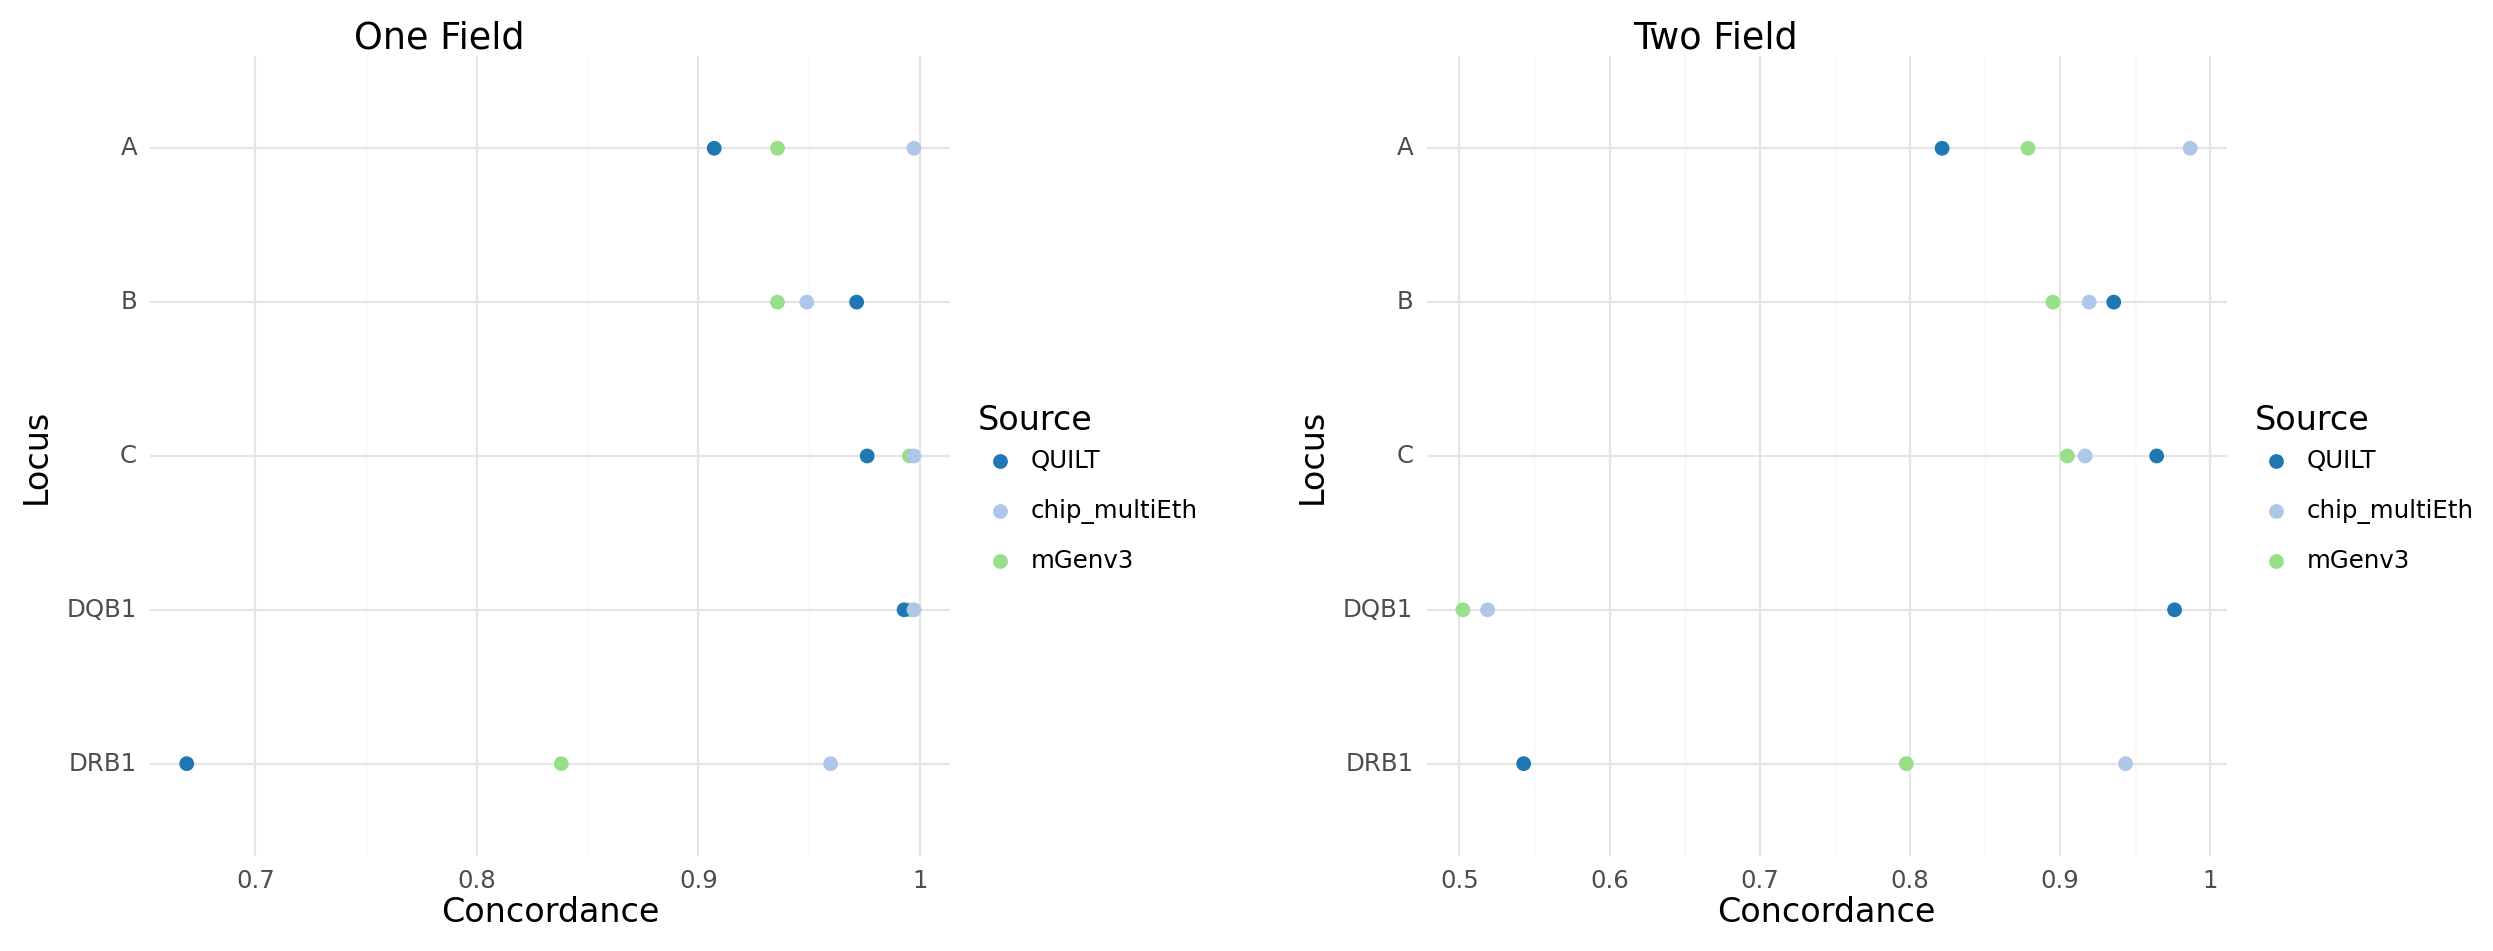

In [33]:
ixs = [0, 1, 5]
p = plot_hla_imputation_accuracy(hla_dirs, labels, indices = ixs)
p